In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import concatenate
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_absolute_error
import csv
from matplotlib import pyplot
from keras.layers import CuDNNLSTM, merge, ConvLSTM2D, Lambda, Conv2DTranspose, Concatenate, Flatten, Conv2D, BatchNormalization, UpSampling2D, MaxPooling2D, MaxPooling3D, UpSampling3D
from keras import losses
from keras.layers import Input, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import pickle
from keras.layers import Bidirectional
import os
import sys
import time
from scipy.spatial import distance
from sklearn.metrics import hamming_loss
import keras.backend as K
import json
from PIL import ImageFilter
import PIL

Using TensorFlow backend.


In [4]:
#loading data
train_image_path = 'cracktree200rgb'
train_mask_path = 'cracktree200_gt'

# val_image_path = 'valdata/images'
# val_mask_path = 'valdata/masks'

# test_image_path = 'test/img'
# test_mask_path = 'test/masks_machine'

In [5]:
def get_data(image_path, mask_path):
    train_images = sorted(os.listdir(image_path))
    mask_images = sorted(os.listdir(mask_path))
    i = 0
    x_nump = []
    y_nump = []
    
    for img in train_images:
        i = i + 1
        per = i / len(train_images) * 100

        x = Image.open(image_path + "/" + img)
#         x = x.resize((256,256),Image.ANTIALIAS)
        x = x.convert('L')

        x = np.array(x)
        x = np.expand_dims(x, -1)
        x_nump.append(x)
    
    for img in mask_images:
        i = i + 1
        per = i / len(train_images) * 100
        
        y = Image.open(mask_path + "/" + img)
#         y = y.resize((256,256),Image.ANTIALIAS)
#         y = y.filter(PIL.ImageFilter.GaussianBlur(radius=1))
#         y = y.convert('L')

        y = np.array(y)
#         y = np.expand_dims(y, -1)
        
        y_nump.append(y)
        
        
    x_nump = np.array(x_nump)
    y_nump = np.array(y_nump)
    
#     print(np.unique(y_nump))
    
#     y_nump = np.where(y_nump==0, 0, y_nump) 
#     y_nump = np.where(y_nump!=0, 255, y_nump) 
    
    y_nump[y_nump == 0] = 0
    y_nump[y_nump != 0] = 1

    return x_nump, y_nump

In [6]:
# x , y = get_data(train_image_path, train_mask_path)

# val_x , val_y = get_data(val_image_path, val_mask_path)

x , y = get_data(train_image_path, train_mask_path)
train_x = x[0:103]
# val_x = x[123:164]
test_x = x[103:]

train_y = y[0:103]
#gaussian blur on train masks
for index in range(len(train_y)):
    temp = Image.fromarray((np.uint8(train_y[index])*255))
    temp = temp.filter(PIL.ImageFilter.GaussianBlur(radius=0.2))
    temp = np.array(temp)
    temp[temp == 0] = 0
    temp[temp != 0] = 1
    train_y[index] = temp

train_y = np.expand_dims(train_y, axis=-1)
# val_y = np.expand_dims(y[123:164], axis=-1)
test_y = np.expand_dims(y[103:], axis=-1)

In [7]:
# print(x.shape, y.shape)

# print(val_x.shape, val_y.shape)
print(train_x.shape, train_y.shape)
# print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(103, 600, 800, 1) (103, 600, 800, 1)
(103, 600, 800, 1) (103, 600, 800, 1)


In [8]:
# print(np.unique(y))
# print(np.unique(train_x, return_counts=False), np.unique(train_y, return_counts=True))
# print(np.unique(test_x), np.unique(test_y))

In [9]:
mean = np.mean(train_x)
std = np.std(train_x)
train_x = (train_x - mean) / std
# val_x = (val_x - mean) / std
test_x = (test_x - mean) / std

# train_x = train_x/255
# val_x = val_x/255
# test_x = test_x/255

In [10]:
# print(np.unique(train_x, return_counts=False), np.unique(train_y, return_counts=True))
# print(np.unique(val_x, return_counts=False), np.unique(val_y, return_counts=True))
# print(np.unique(test_x, return_counts=False), np.unique(test_y, return_counts=True))

In [11]:
# print(train_x.shape)
# i = 0
# for sequence in range(len(train_x)):
#     i = i + 1
#     print(i)
# #     plt.imshow(train_x[sequence], cmap='gray')
#     plt.imshow(np.reshape(train_x[sequence], (600,800)), cmap='gray')
#     plt.pause(0.005)

In [12]:
# print(train_y.shape)
# i = 0
# for sequence in range(len(train_y)):
#     i = i + 1
#     print(i)
#     plt.imshow(np.reshape(train_y[sequence], (600,800)), cmap='gray')
#     plt.pause(0.005)

In [13]:
#row by row sequence
def stretch_data(x_train, y_train):
    x_sequence = list()
    y_sequence = list()

#     np.zeros((256, 256, 1))
    
    for img in x_train:
        for row in img:
            x_sequence.append(row)
            
    for img in y_train:
        for row in img:
            y_sequence.append(row)
        
    return np.array(x_sequence), np.array(y_sequence)

In [14]:
# x_train_sequence, y_train_sequence = stretch_data(x,y)
# x_val_sequence, y_val_sequence = stretch_data(val_x,val_y)
x_train_sequence, y_train_sequence = stretch_data(train_x,train_y)
# val_x_train_sequence, val_y_train_sequence = stretch_data(val_x,val_y)
test_x_train_sequence, test_y_train_sequence = stretch_data(test_x,test_y)

In [15]:
print(x_train_sequence.shape , y_train_sequence.shape)
# print(val_x_train_sequence.shape , val_y_train_sequence.shape)
print(test_x_train_sequence.shape , test_y_train_sequence.shape)
# x_min =  np.amin(x_test_sequence)
# y_min =  np.amin(y_test_sequence)
# x_max = np.amax(x_test_sequence)
# y_max = np.amax(y_test_sequence)
# x_test_sequence = (x_test_sequence - x_min)/(x_max - x_min)
# y_test_sequence = (y_test_sequence -y_min)/(y_max - y_min)

# print(x_val_sequence.shape , y_val_sequence.shape)
# print(np.unique(x_test_sequence), np.unique(y_test_sequence))
# print(x_test_sequence.shape , y_test_sequence.shape)

(61800, 800, 1) (61800, 800, 1)
(61800, 800, 1) (61800, 800, 1)


In [16]:
def get_sequence(x_train, y_train, time_step, window):
    amount_of_features = x_train.shape[1]
    sequence_length = time_step
    x_result = []
    y_result = []
    
    x_seq_res = []
    y_seq_res = []
    #Dividing the complete image sequence into blocks of shape window x features
    #Image 
    for index in range(0,len(x_train), window):
        x_result.append(x_train[index: index + window])
    #Mask
    for index in range(0,len(y_train), window):
        y_result.append(y_train[index: index + window])
        
    x_result = np.array(x_result)
    y_result = np.array(y_result)   
    
    print(x_result.shape)
    print(y_result.shape)
    
#     print(x_result)
#     print(y_result)

    
    #Making the sequence of shape time_step x window x features
    #Image 
    for index in range(len(x_result) - sequence_length):
        x_seq_res.append(x_result[index: index + sequence_length])
    #Mask
    for index in range(len(y_result) - sequence_length):
        y_seq_res.append(y_result[index + sequence_length - 1])
    
    
    #testing
#     plt.imshow(x_result[280] * y_result[0:280], cmap='gray')
    
#     #checking if equal
#     if(np.array_equal(np.array(x_train[559:839]), np.array(x_result[559]))):
#         print("Correct")
#     else:
#         print("Wrong")

    x_seq_res = np.array(x_seq_res)
    y_seq_res = np.array(y_seq_res)
    
    print(x_seq_res.shape, y_seq_res.shape)
    
#     total_images = len(x_result)//sequence_length
#     test_image = (total_images * 0.1)
#     x_row = ((int(total_images - test_image) * sequence_length) - sequence_length)
#     y_row = ((int(total_images - test_image) * sequence_length) - sequence_length)
    
#     x_sequence_train = x_seq_res[:int(x_row), :]
#     y_sequence_train = y_seq_res[:int(y_row), :]
     
#     x_sequence_test = x_seq_res[int(x_row):, :]
#     y_sequence_test = y_seq_res[int(x_row):, :]

#     x_sequence_train = np.reshape(x_sequence_train, (x_sequence_train.shape[0], x_sequence_train.shape[1], x_sequence_train.shape[2], amount_of_features,3))
#     x_sequence_test = np.reshape(x_sequence_test, (x_sequence_test.shape[0], x_sequence_test.shape[1], x_sequence_test.shape[2], amount_of_features,3))
    
#     y_sequence_train = np.reshape(y_sequence_train, (y_sequence_train.shape[0], y_sequence_train.shape[1], y_sequence_train.shape[2],1))
#     y_sequence_test = np.reshape(y_sequence_test, (y_sequence_test.shape[0], y_sequence_test.shape[1], y_sequence_test.shape[2],1))
    
#     print('X_Y_train: ', x_sequence_train.shape , y_sequence_train.shape)
    
#     print('X_Y_TEST', x_sequence_test.shape , y_sequence_test.shape)
    
    return [x_seq_res, y_seq_res]

In [17]:
# x_train, y_train = get_sequence(x_train_sequence, y_train_sequence, 32, 1)
# x_val, y_val = get_sequence(x_val_sequence, y_val_sequence, 32, 1)
x_train, y_train = get_sequence(x_train_sequence, y_train_sequence, 8, 1)
# val_x_train, val_y_train = get_sequence(val_x_train_sequence, val_y_train_sequence, 8, 1)
test_x_train, test_y_train = get_sequence(test_x_train_sequence, test_y_train_sequence, 8, 1)

(61800, 1, 800, 1)
(61800, 1, 800, 1)
(61792, 8, 1, 800, 1) (61792, 1, 800, 1)
(61800, 1, 800, 1)
(61800, 1, 800, 1)
(61792, 8, 1, 800, 1) (61792, 1, 800, 1)


In [18]:
# print(np.unique(x_train), np.unique(y_train))
# print(np.unique(x_val), np.unique(y_val))
# print(np.unique(x_test), np.unique(y_test))

In [19]:
def np_mean_iou(labels, predictions, n_classes=2):
    mean_iou = 0.0
    seen_classes = 0

    for c in range(n_classes):
        labels_c = (labels == c)
        pred_c = (predictions == c)

        labels_c_sum = (labels_c).sum()
        pred_c_sum = (pred_c).sum()

        if (labels_c_sum > 0) or (pred_c_sum > 0):
            seen_classes += 1

            intersect = np.logical_and(labels_c, pred_c).sum()
            union = labels_c_sum + pred_c_sum - intersect

            mean_iou += intersect / union

    return mean_iou / seen_classes if seen_classes else 0

def compute_iou(gt, pt):
    intersection = np.sum(gt * pt)
    u = gt + pt
    u[u > 0] = 1
    union = np.sum(u)
    return intersection / union

In [20]:
# def mean_iou(y_true, y_pred):
#     score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
#     K.get_session().run(tf.local_variables_initializer())
#     with tf.control_dependencies([up_opt]):
#         score = tf.identity(score)
#     return score

def mean_iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection) / (union + K.epsilon()), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    # some implementations don't square y_pred
    denominator = tf.reduce_sum(y_true + tf.square(y_pred))

    return numerator / (denominator + tf.keras.backend.epsilon())

In [21]:
# def dice_coef(y_true, y_pred,smooth=1e-7):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1 - dice_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection)/(union + K.epsilon()), axis=0)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [22]:
# def jaccard_distance_loss(y_true, y_pred, smooth=100):
#     """ Calculates mean of Jaccard distance as a loss function """
#     intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
#     sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     jd =  (1 - jac) * smooth
#     return jd

# def jaccard_distance(y_true, y_pred, smooth=100):
#     """ Calculates mean of Jaccard distance as a loss function """
#     intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
#     sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return jac

In [23]:
# def loss(y_true, y_pred):
# #     def dice_loss(y_true, y_pred):
# #         numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
# #         denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

# #         return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

#     return K.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
# #     return dice_coef_loss(y_true, y_pred)

In [24]:
def binary_focal_loss_fixed(y_true, y_pred, smooth = 1.0):
    
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.zeros_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    
    intersection = K.sum(pt_1, axis=[1,2,3])
    false_negative = K.sum(pt_0, axis=[1,2,3]) 
    
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection)/(union + K.epsilon()), axis=0)
    
    return (1-dice)

In [25]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
def loss(y_true, y_pred):
#     def dice_loss(y_true, y_pred):
#         numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
#         denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

#         return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return 1 - f1_m(y_true, y_pred)
#     return dice_coef_loss(y_true, y_pred)

In [27]:
# Attention_Cracktree_grayscale_input_2_layer_tanh_softmax_loss_dice_loss_epochs_100_bs_64_input_8_1_800
def get_model(pretrained_weights = None,input_size = (8, 1, 800, 1)):
    inputs = Input(input_size)
    
    #DownSampling
    #128
    conv1 = (ConvLSTM2D(64, kernel_size=(1,9), activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(inputs)
    bnorm1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.2)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)

#     attention_probs = Dense(64 ,activation='softmax', name='attention_probs')(conv1)
#     attention_mul = merge([conv1, attention_probs], name='attention_mul', mode='mul')
    

    
    #64
#     conv2 = (ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(maxpool1)
#     bnorm2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.0)(bnorm2)
#     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

    #UpSampling
    #128
#     conv3 = (ConvLSTM2D(256, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(maxpool2)
#     bnorm3 = BatchNormalization()(conv3)
#     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
#     merge1 = concatenate([maxpool1,up1], axis = 4)
#     drop3 = Dropout(0.0)(merge1)
    
    #256
#     conv4 = (ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(drop3)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.0)(up2)
    
#     conv5 = ConvLSTM2D(64, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop4)
    
#     conv6 = ConvLSTM2D(4, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv5)
#     conv7 = ConvLSTM2D(2, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv6)
    conv5 = ConvLSTM2D(1, kernel_size=(1,9), activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop1)
    
#     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
    #Model                     
    model = Model(input = inputs, output = conv5)
    
#     model = make_parallel(model, gpu_count=2)

    
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-3), loss = loss , metrics = ['accuracy', dice_coef, mean_iou, recall_m, precision_m, f1_m])
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)

    return model

In [28]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 1, 800, 1)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 8, 1, 800, 64)     150016    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 1, 800, 64)     256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 1, 800, 64)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 800, 1)         2344      
Total params: 152,616
Trainable params: 152,488
Non-trainable params: 128
_________________________________________________________________


In [29]:
model = get_model('Smooth_50_50_split_Cracktree_grayscale_input_2_layer_tanh_softmax_loss_dice_loss_epochs_100_bs_64_input_8_1_800.hdf5')
# model_checkpoint = keras.callbacks.ModelCheckpoint('Smooth_50_50_split_Cracktree_grayscale_input_2_layer_tanh_softmax_loss_dice_loss_epochs_100_bs_64_input_8_1_800.hdf5', monitor='val_f1_m', mode='max', verbose=1, save_best_only=True)
# history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.1, verbose=1, callbacks=[model_checkpoint])

# with open('Smooth_50_50_split_Cracktree_grayscale_input_2_layer_tanh_softmax_loss_dice_loss_epochs_100_bs_64_input_8_1_800.json', 'w') as f:
#     json.dump(history.history, f)

loading_weights


In [30]:
# print(history)

In [31]:
model.metrics_names

['loss', 'acc', 'dice_coef', 'mean_iou', 'recall_m', 'precision_m', 'f1_m']

In [32]:
score = model.evaluate(test_x_train, test_y_train)
print(model.metrics_names, score)

61792/61792 [==============================] - 129s 2ms/step
['loss', 'acc', 'dice_coef', 'mean_iou', 'recall_m', 'precision_m', 'f1_m'] [0.7689744353849983, 0.9902136823107455, 0.21792383010768424, 0.13734385468968274, 0.5474743349963567, 0.15815849899835108, 0.2310255645352111]


In [33]:
time1 = time.time()
y_pred = model.predict(test_x_train)
time2 = time.time()
print('{:s} function took {:.3f} ms', (time2-time1))

{:s} function took {:.3f} ms 123.56844282150269


In [34]:
print(np.unique(y_pred, return_counts=True))

(array([0.000000e+00, 4.917383e-06, 8.374453e-06, ..., 9.999914e-01,
       9.999998e-01, 1.000000e+00], dtype=float32), array([48818555,        1,        1, ...,        1,        1,   434694]))


(61792, 1, 800, 1)
(61800, 1, 800, 1)
1


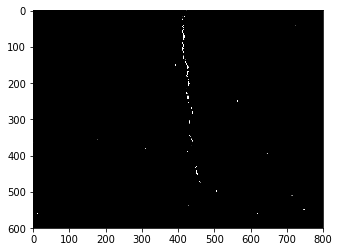

2


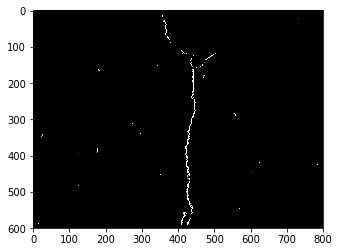

3


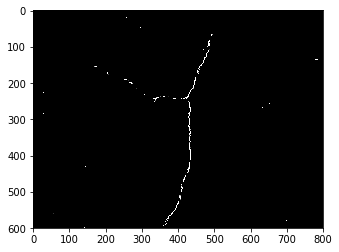

4


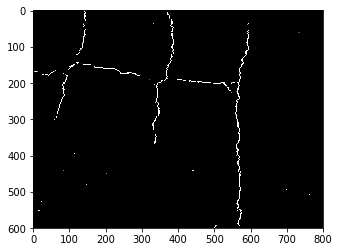

5


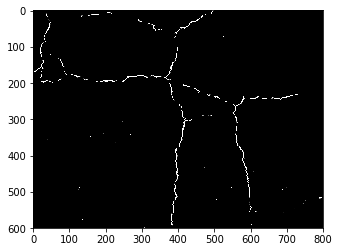

6


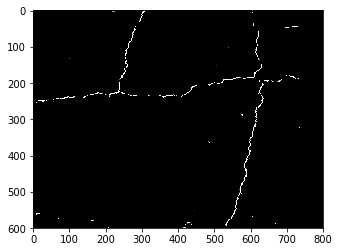

7


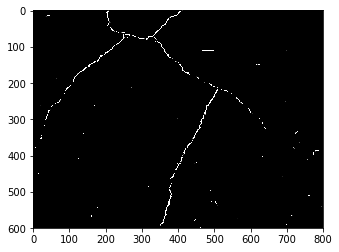

8


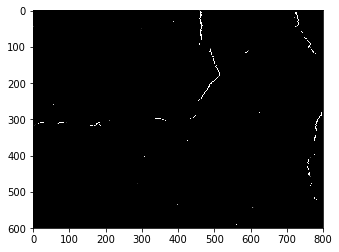

9


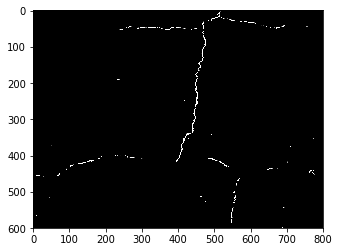

10


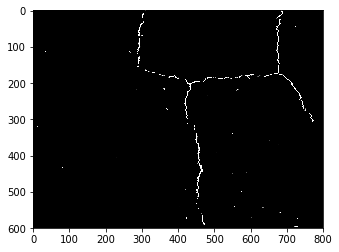

11


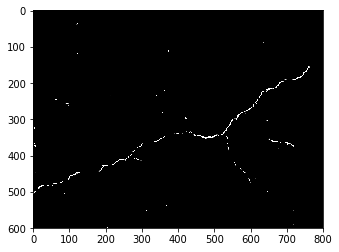

12


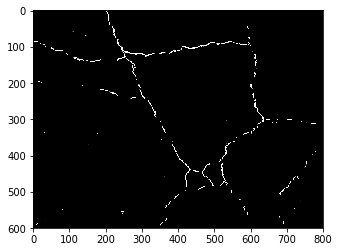

13


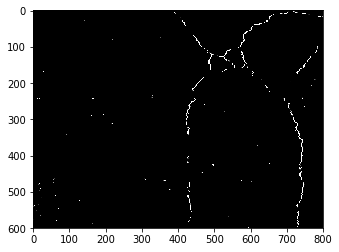

14


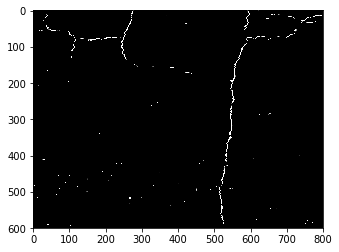

15


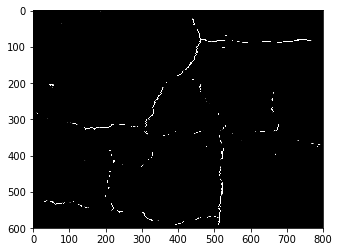

16


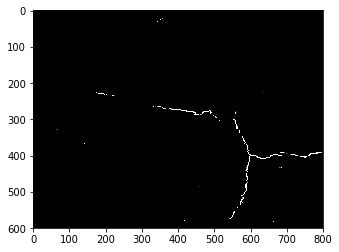

17


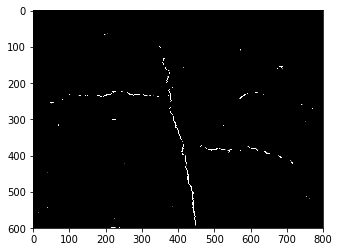

18


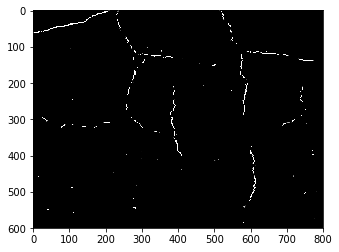

19


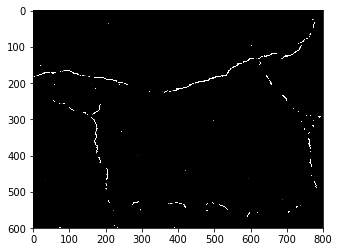

20


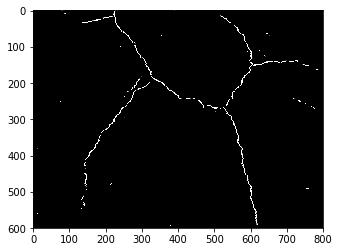

21


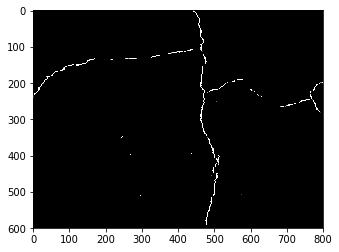

22


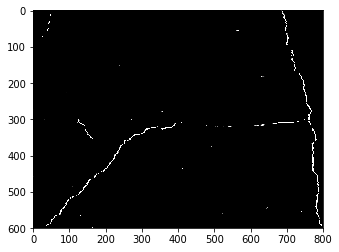

23


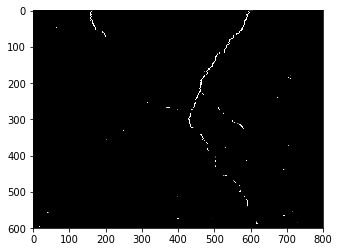

24


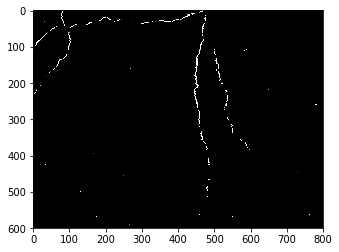

25


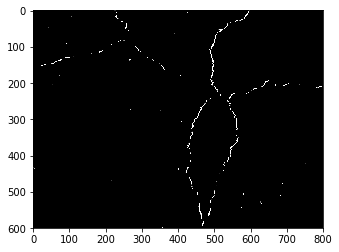

26


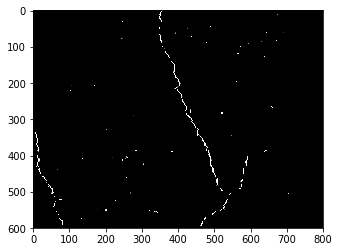

27


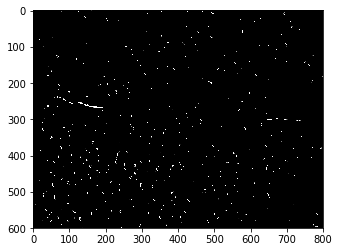

28


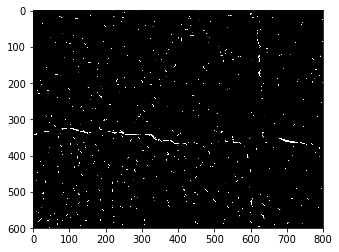

29


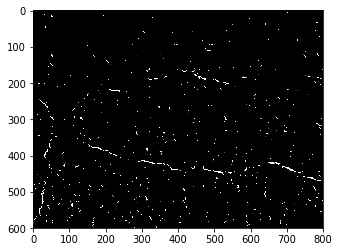

30


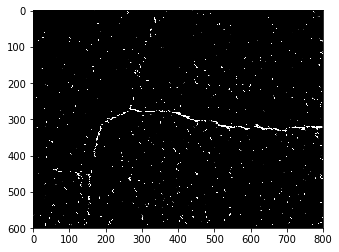

31


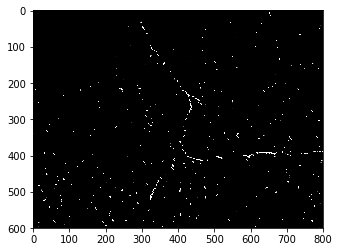

32


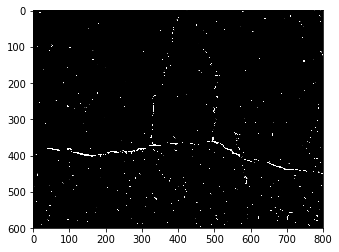

33


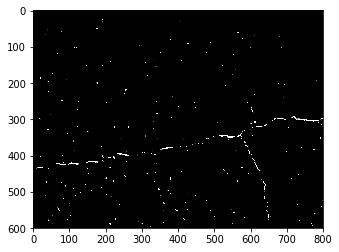

34


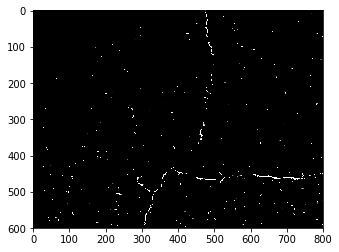

35


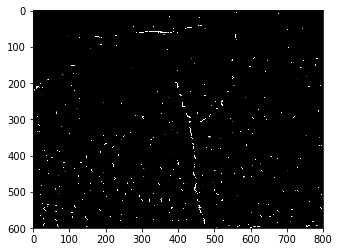

36


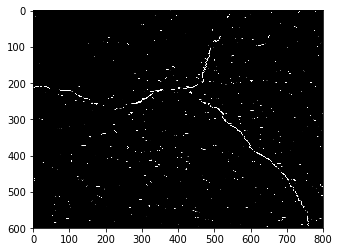

37


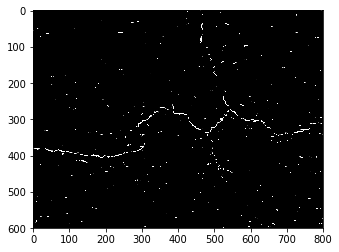

38


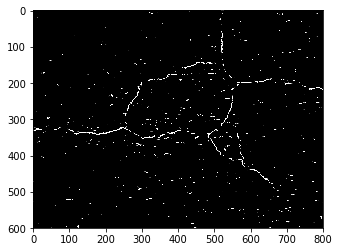

39


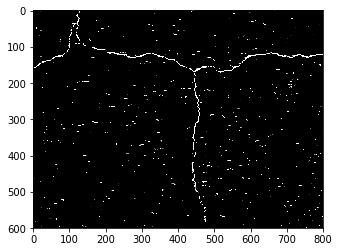

40


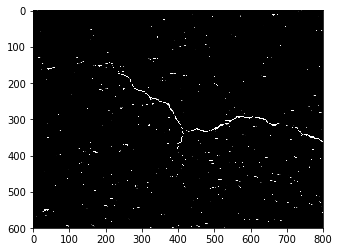

41


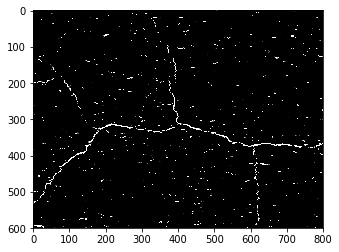

42


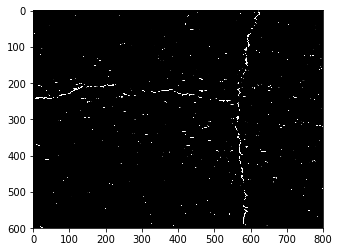

43


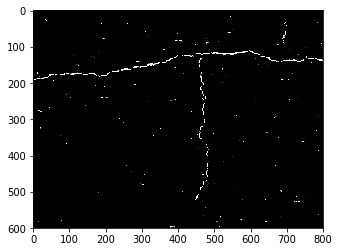

44


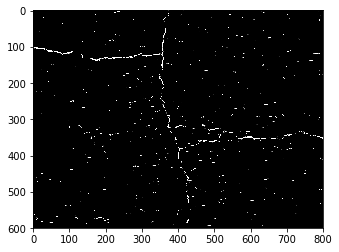

45


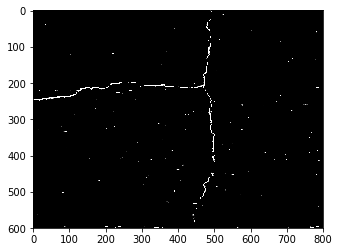

46


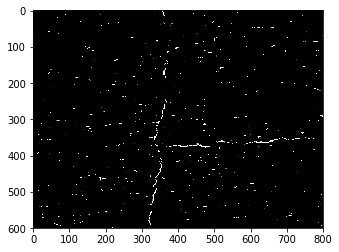

47


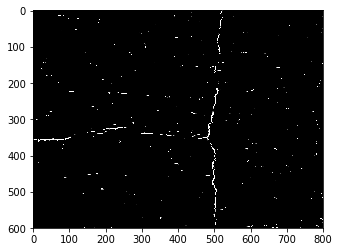

48


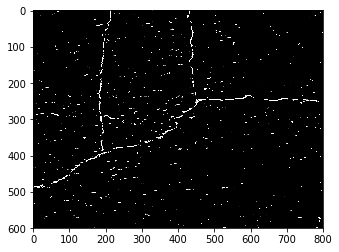

49


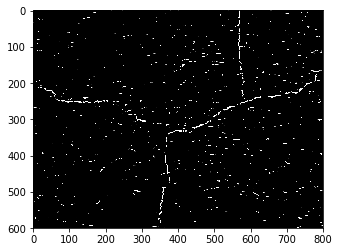

50


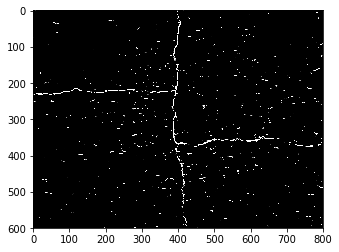

51


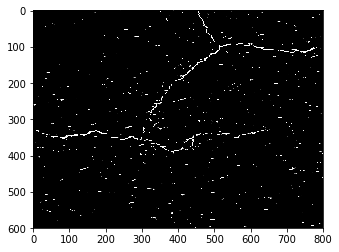

52


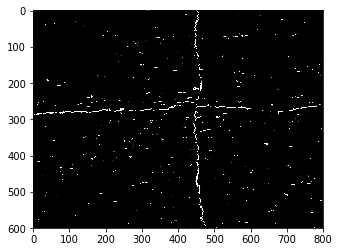

53


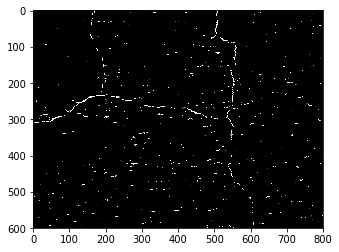

54


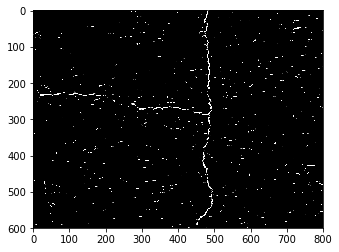

55


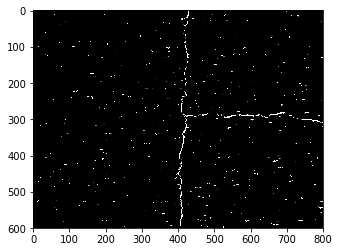

56


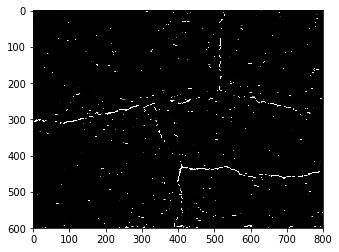

57


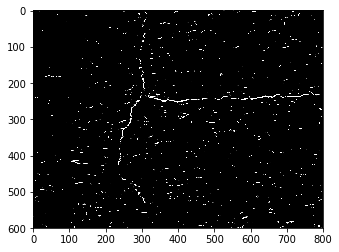

58


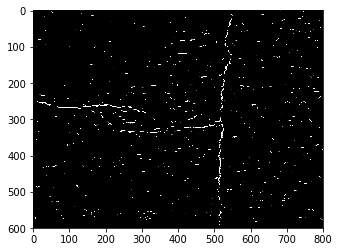

59


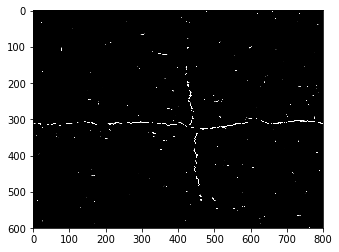

60


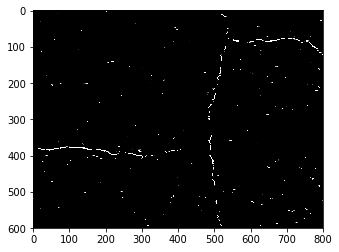

61


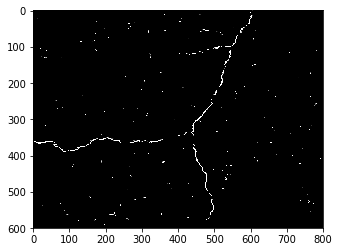

62


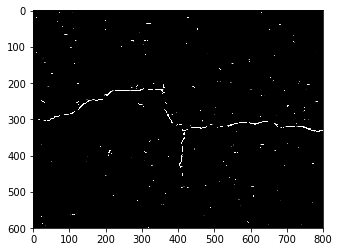

63


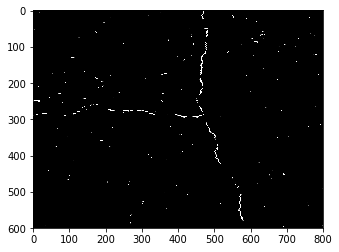

64


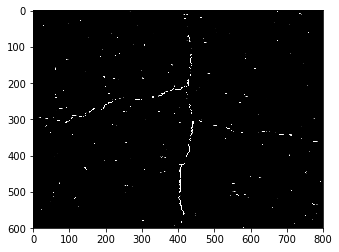

65


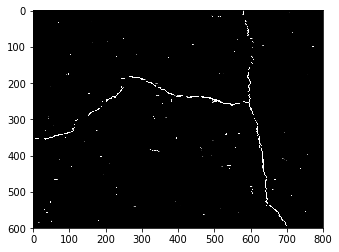

66


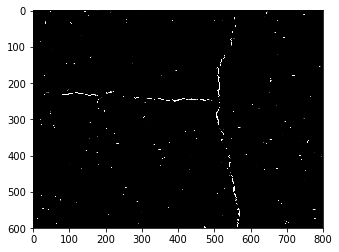

67


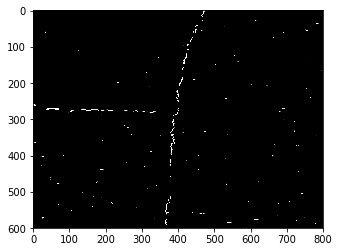

68


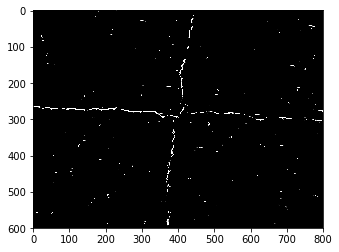

69


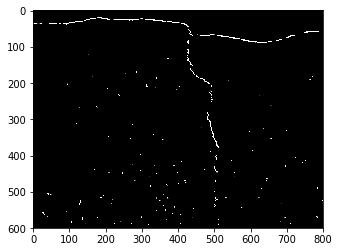

70


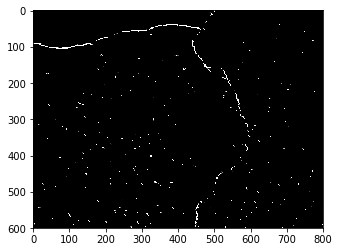

71


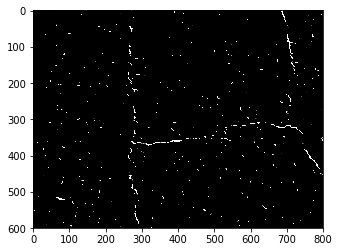

72


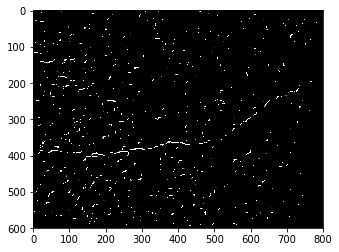

73


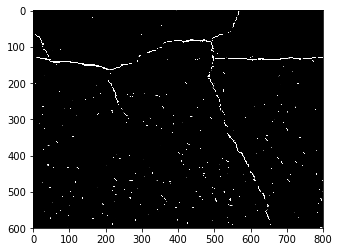

74


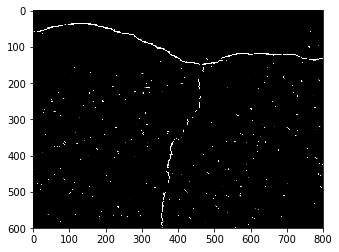

75


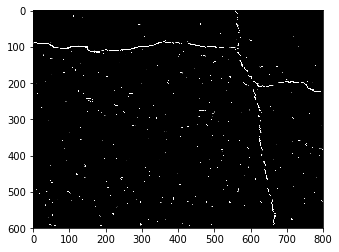

76


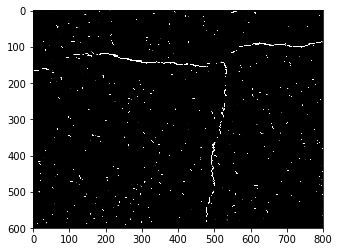

77


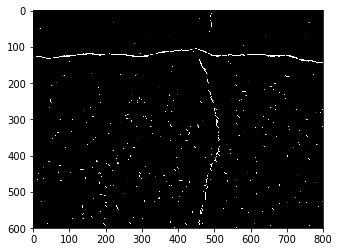

78


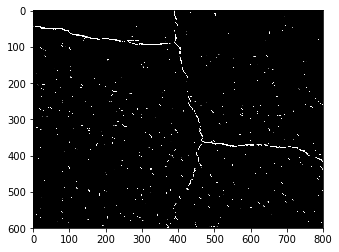

79


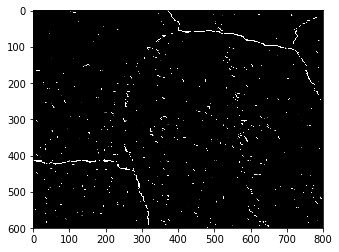

80


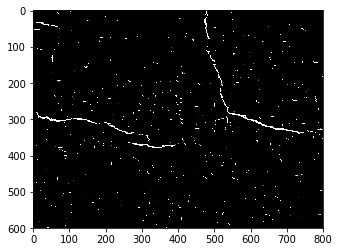

81


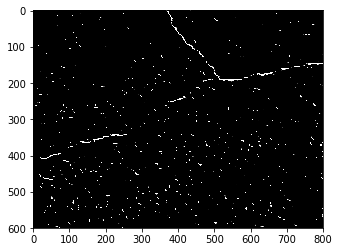

82


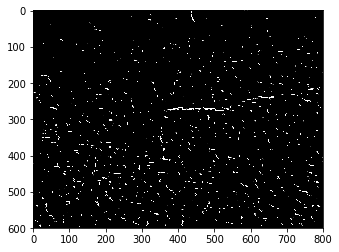

83


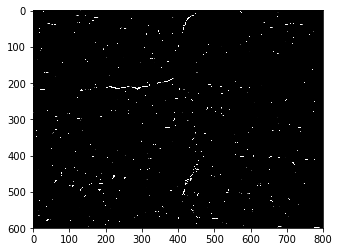

84


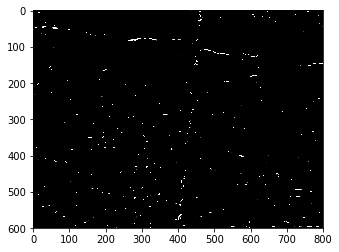

85


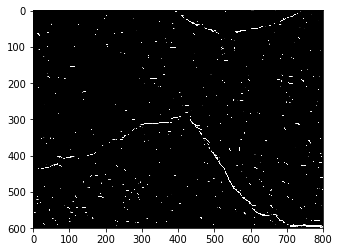

86


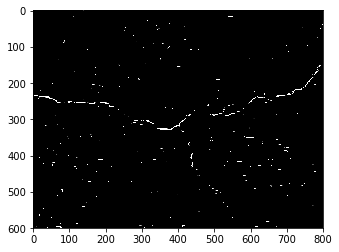

87


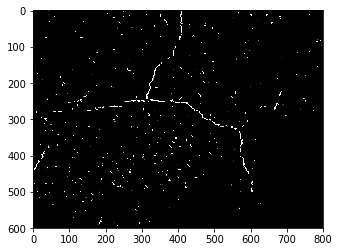

88


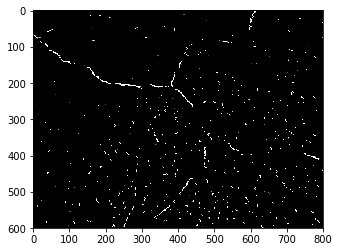

89


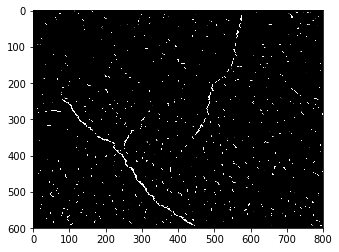

90


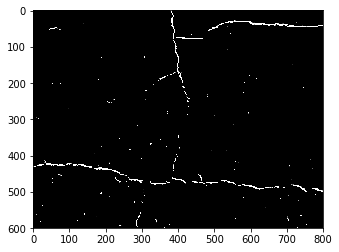

91


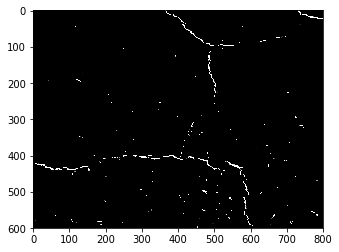

92


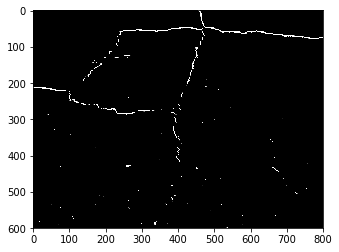

93


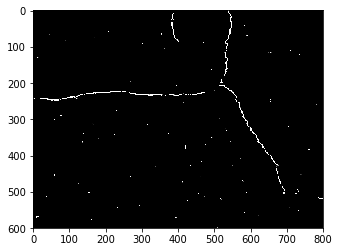

94


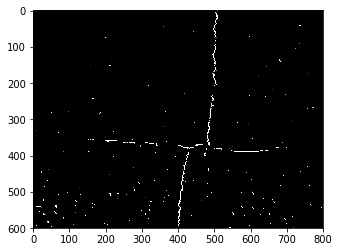

95


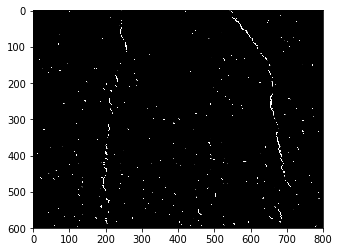

96


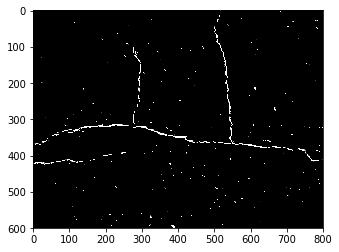

97


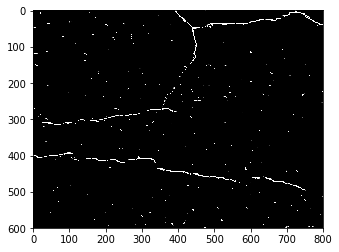

98


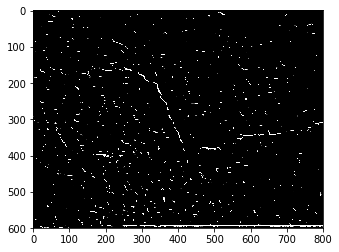

99


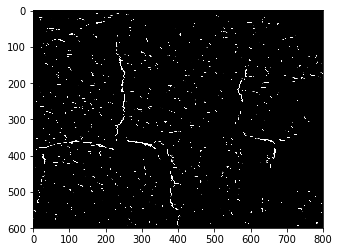

100


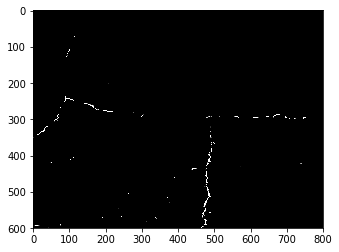

101


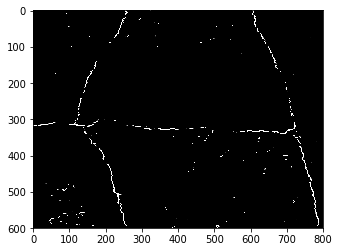

102


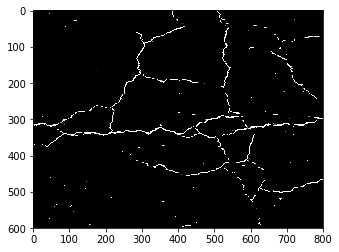

103


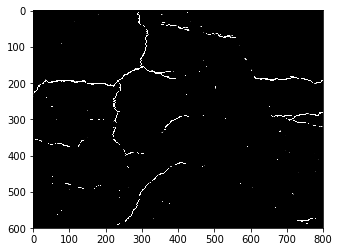

In [35]:
print(y_pred.shape)
temp = np.zeros((8, 1, 800, 1))
y_pred = np.append(y_pred, temp, axis = 0)
print(y_pred.shape)
temp_y = np.reshape(y_pred, (103, 600, 800))
# y_pred = y_pred[:37376]
# y_pred = y_pred.reshape(146, 224, 224)
# # y_pred[y_pred >= 0.5] = 1
# # y_pred[y_pred < 0.5] = 0
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

(61792, 1, 800, 1)
(61800, 1, 800, 1)
1


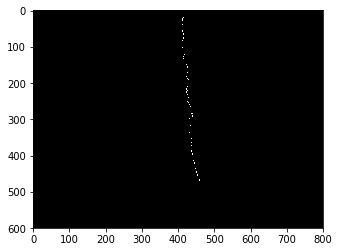

2


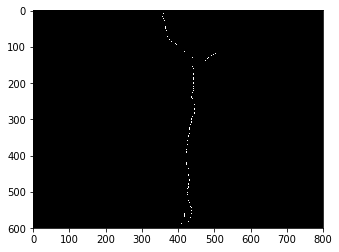

3


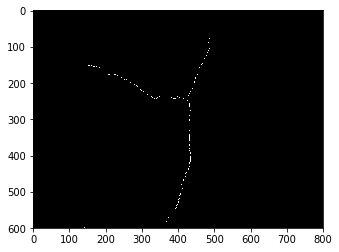

4


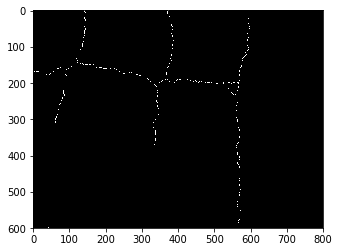

5


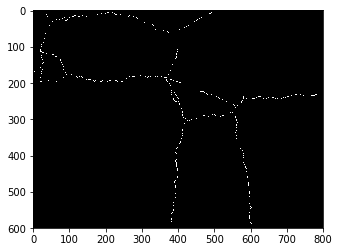

6


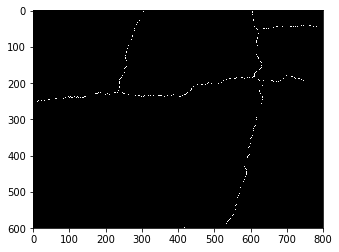

7


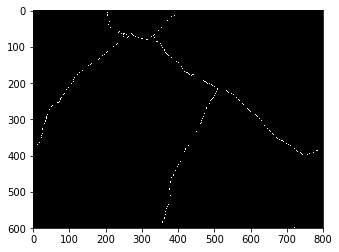

8


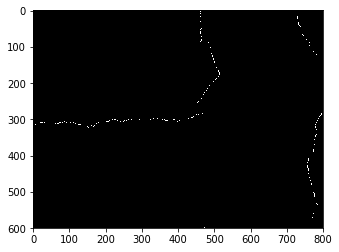

9


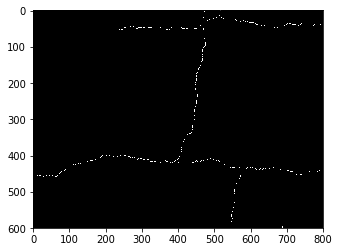

10


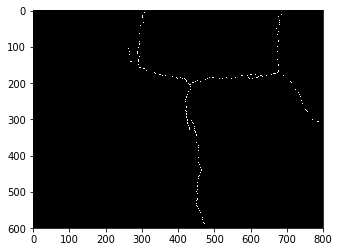

11


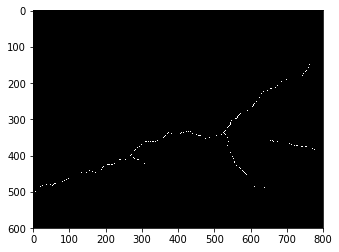

12


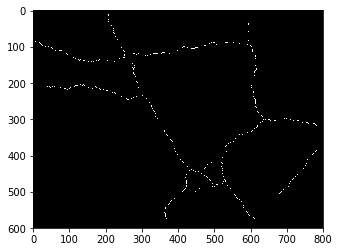

13


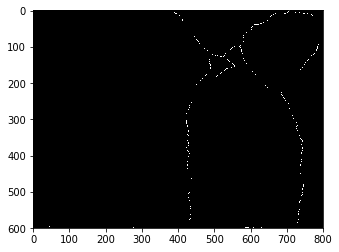

14


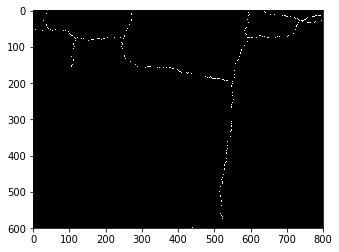

15


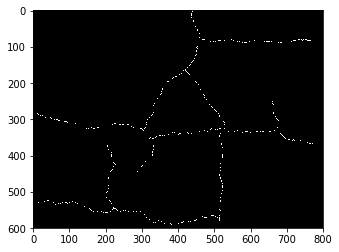

16


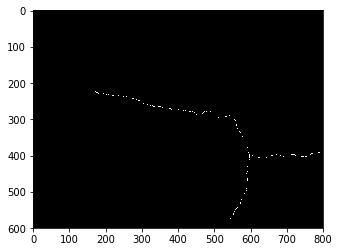

17


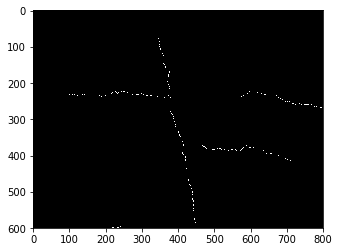

18


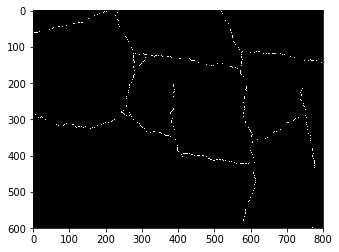

19


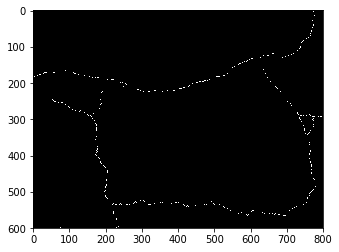

20


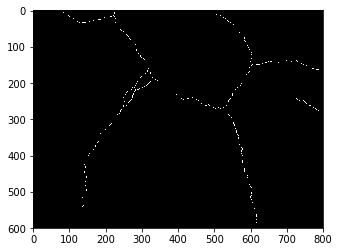

21


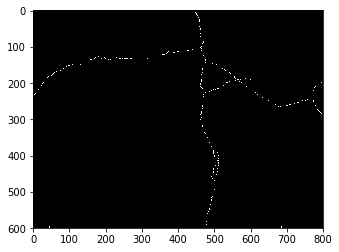

22


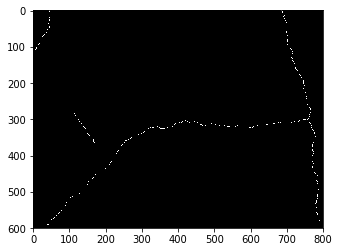

23


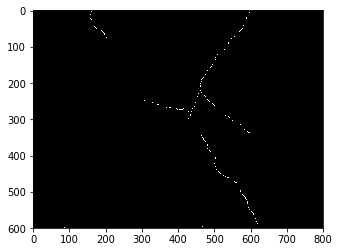

24


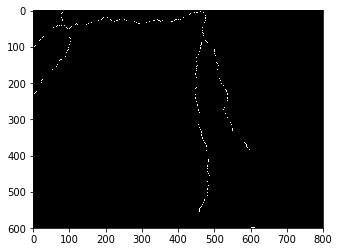

25


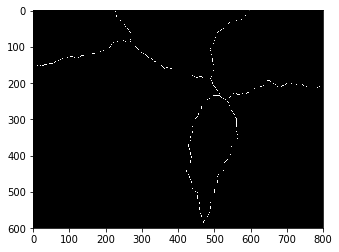

26


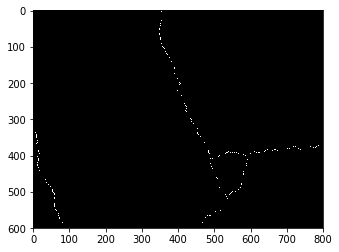

27


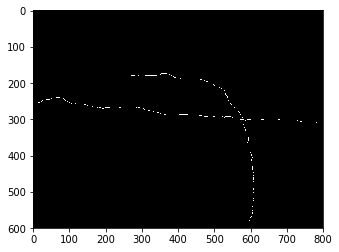

28


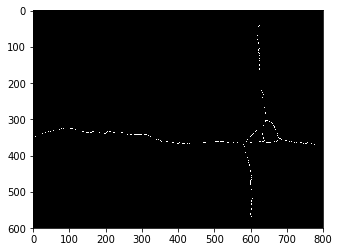

29


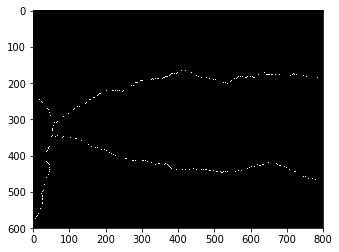

30


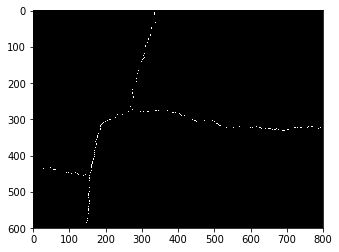

31


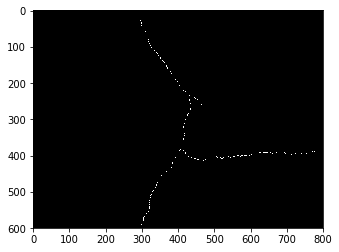

32


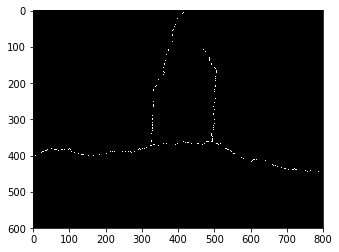

33


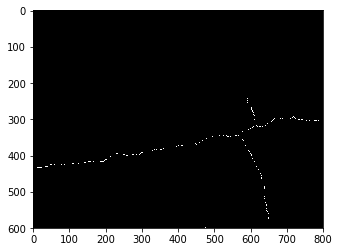

34


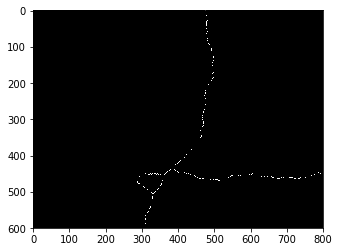

35


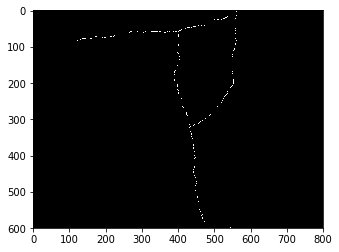

36


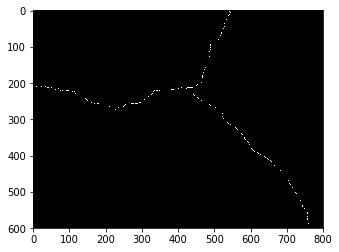

37


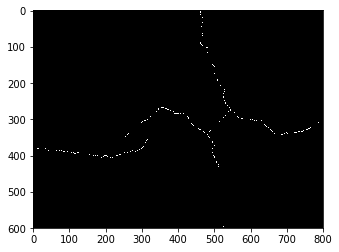

38


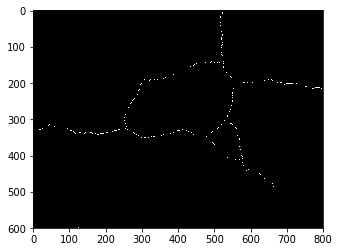

39


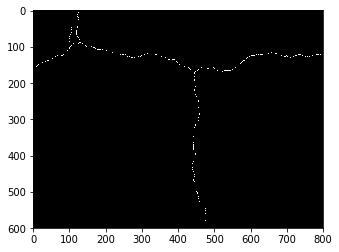

40


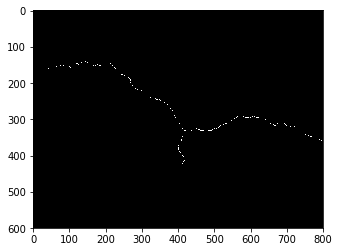

41


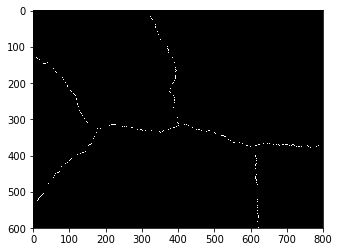

42


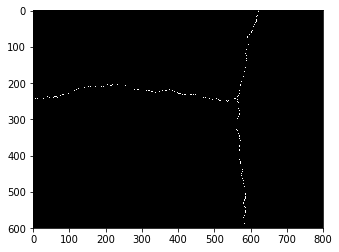

43


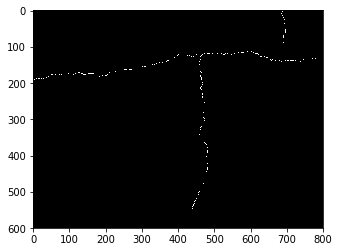

44


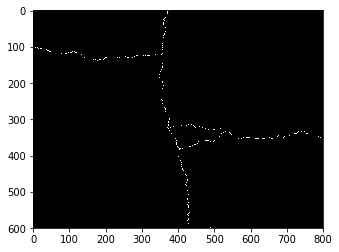

45


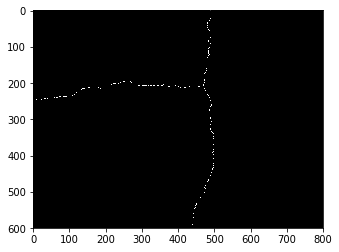

46


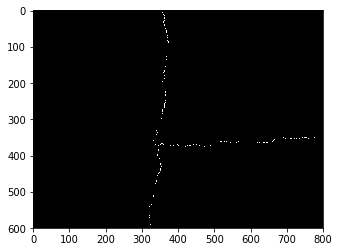

47


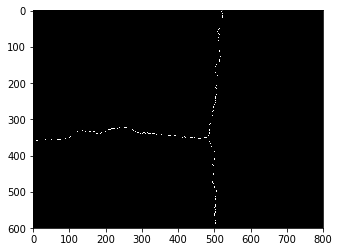

48


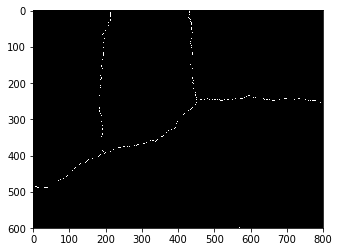

49


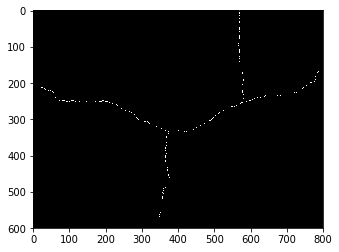

50


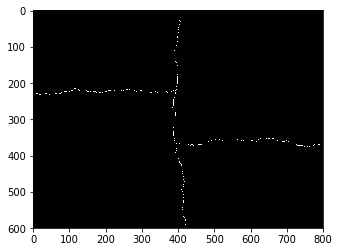

51


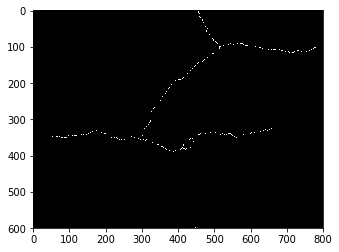

52


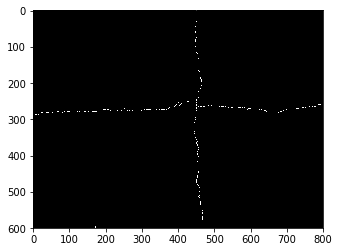

53


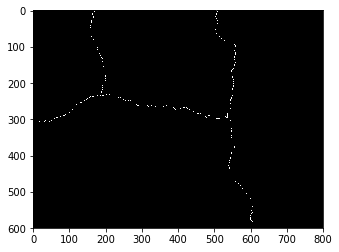

54


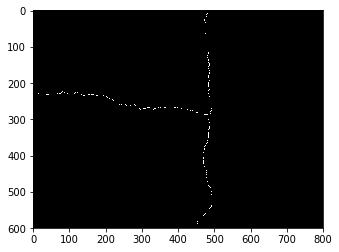

55


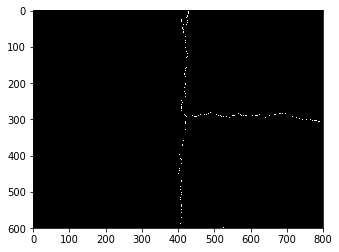

56


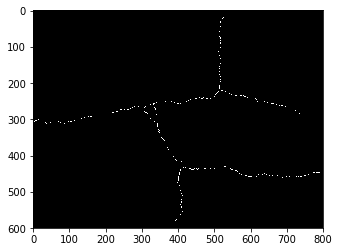

57


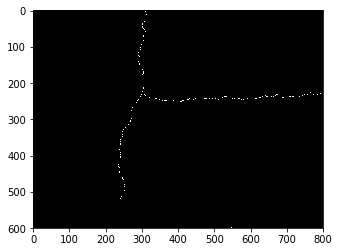

58


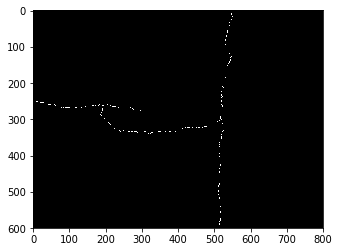

59


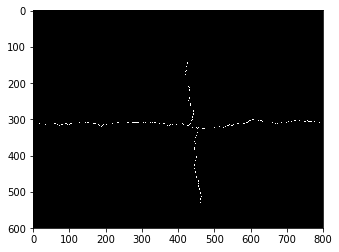

60


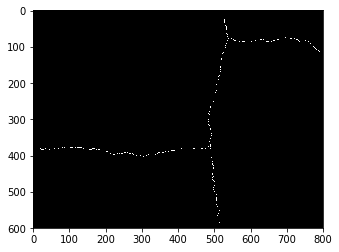

61


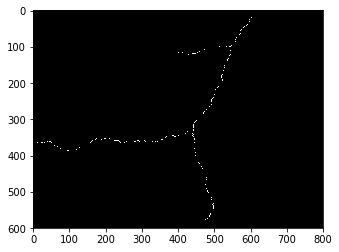

62


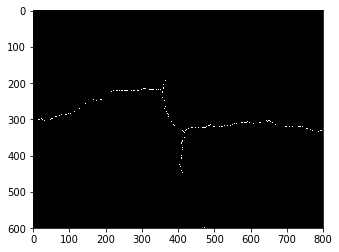

63


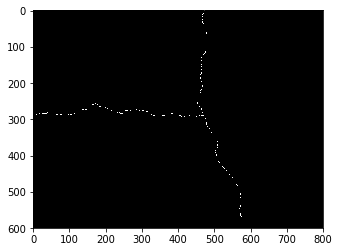

64


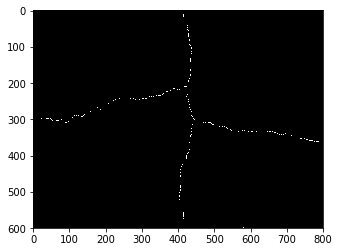

65


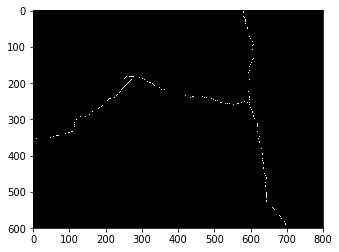

66


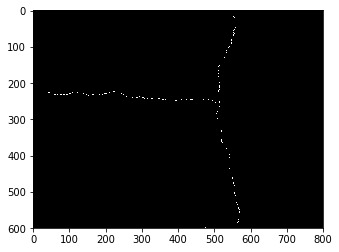

67


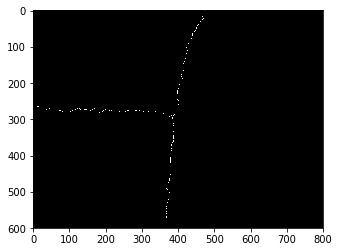

68


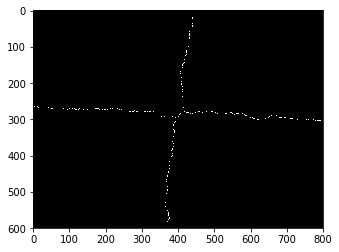

69


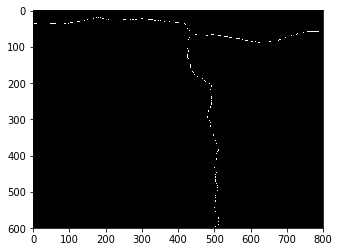

70


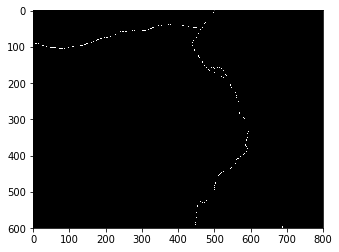

71


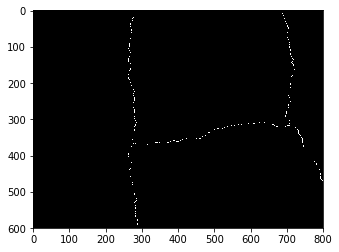

72


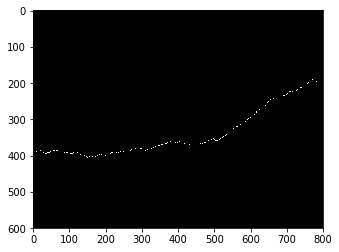

73


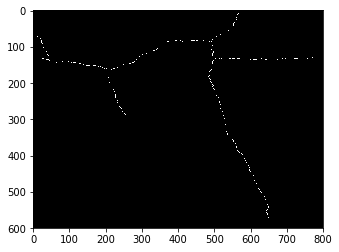

74


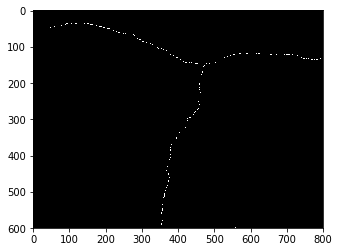

75


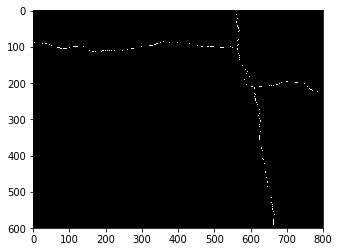

76


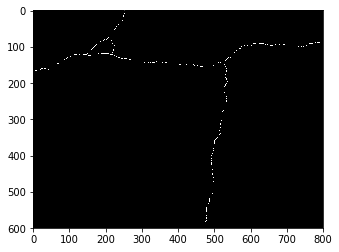

77


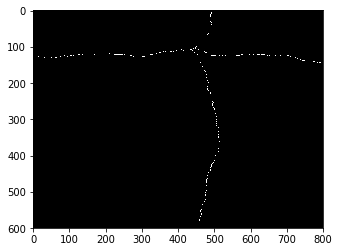

78


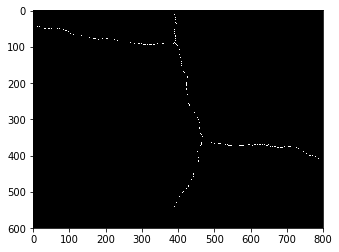

79


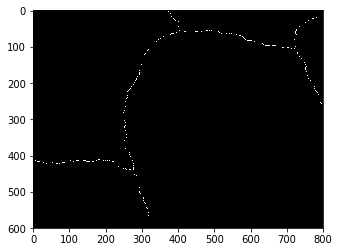

80


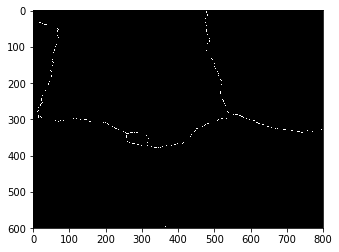

81


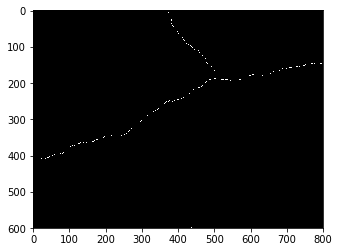

82


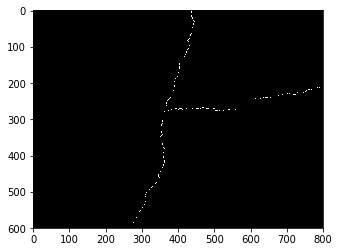

83


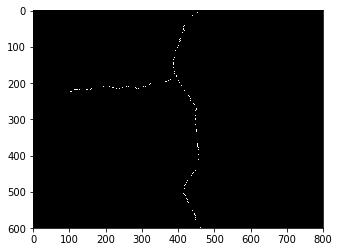

84


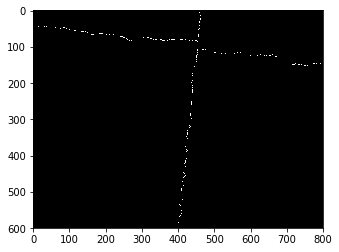

85


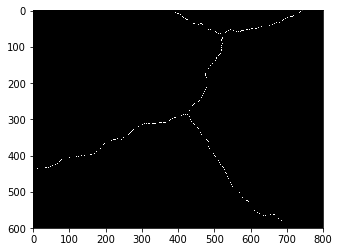

86


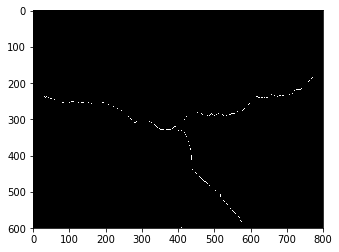

87


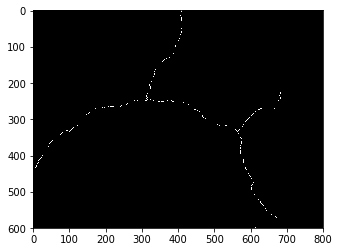

88


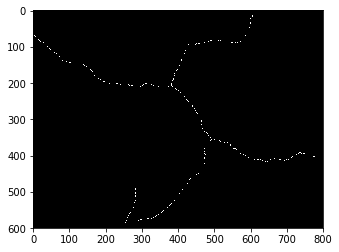

89


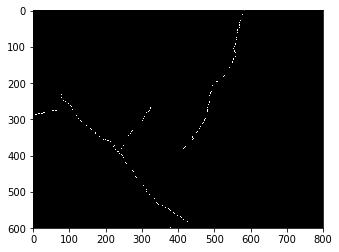

90


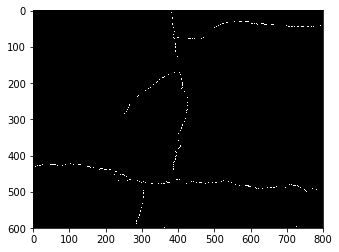

91


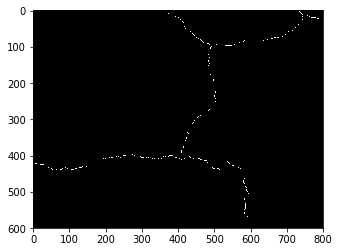

92


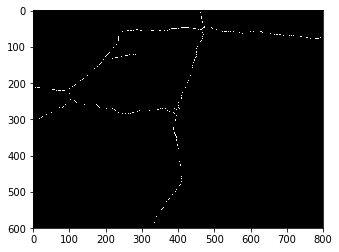

93


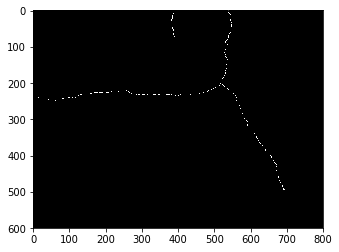

94


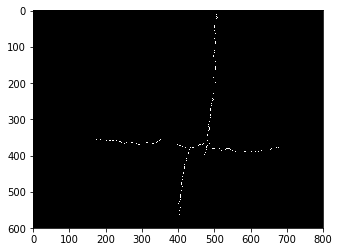

95


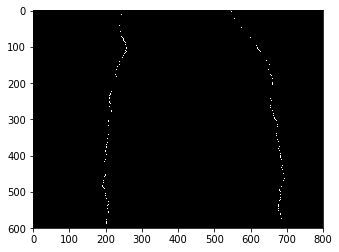

96


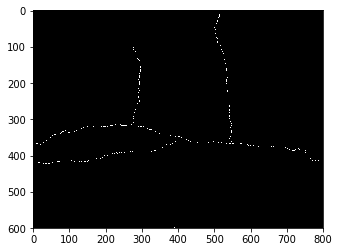

97


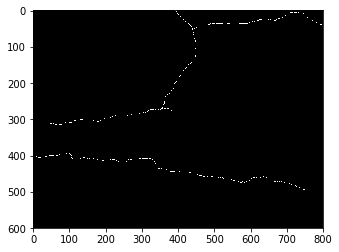

98


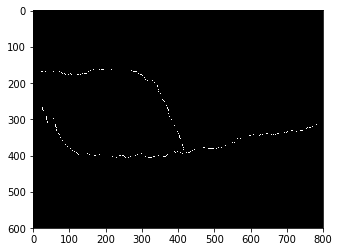

99


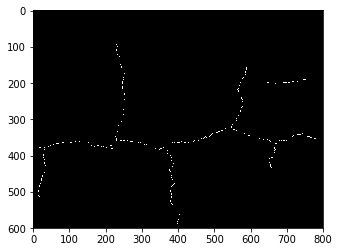

100


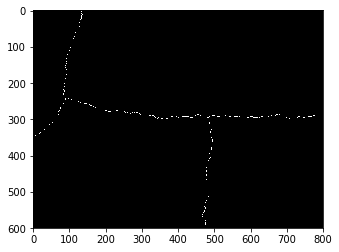

101


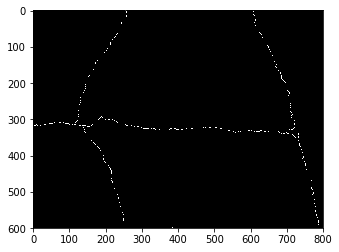

102


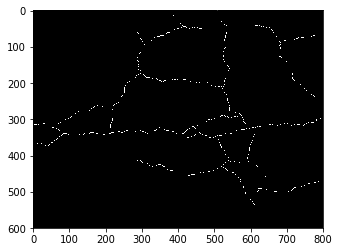

103


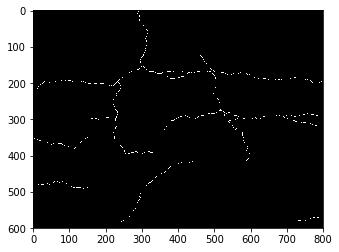

In [36]:
print(test_y_train.shape)
temp = np.zeros((8, 1, 800, 1))
test_y_train = np.append(test_y_train, temp, axis = 0)
print(test_y_train.shape)
temp_y = np.reshape(test_y_train, (103, 600, 800))
# y_pred = y_pred[:37376]
# y_pred = y_pred.reshape(146, 224, 224)
# # y_pred[y_pred >= 0.5] = 1
# # y_pred[y_pred < 0.5] = 0
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

In [37]:
def concat_img(data):
    frames = list()
    row_len = 600
    for rows in range(0,len(data), row_len):
        frames.append(data[rows:rows+row_len])
    frames = np.array(frames)
#     return np.squeeze(frames, axis=0)
    return frames

In [38]:
frames_img = concat_img(y_pred)
print(frames_img.shape)

(103, 600, 1, 800, 1)


In [39]:
y_frames_img = concat_img(test_y_train)
print(y_frames_img.shape)

(103, 600, 1, 800, 1)


In [40]:
frames_img = np.reshape(frames_img, (103,600,800))
y_frames_img = np.reshape(y_frames_img, (103,600,800))

In [41]:
smooth = 1
intersection = np.sum(np.multiply(y_frames_img[0] ,frames_img[0]))
union = np.sum(y_frames_img[0]) + np.sum(frames_img[0])
print(np.unique(union))
iou = (2. * intersection + smooth) / (union + smooth)
print(iou)

[1284.52217162]
0.3477539346722993


1


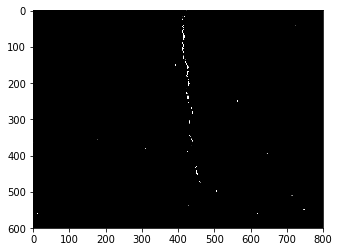

2


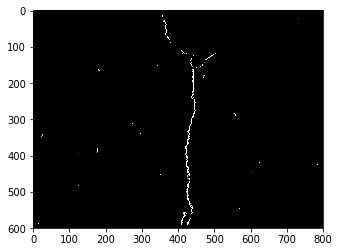

3


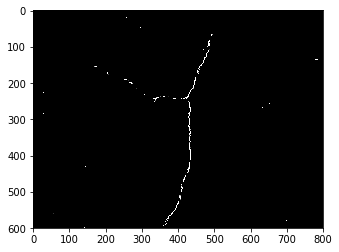

4


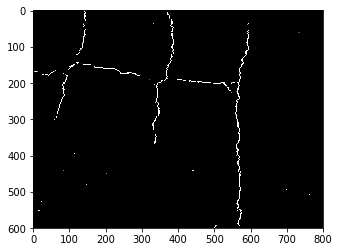

5


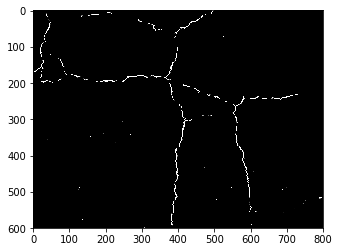

6


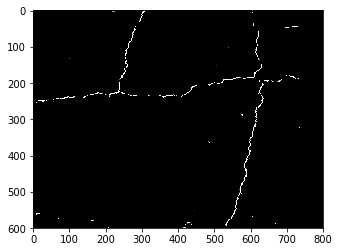

7


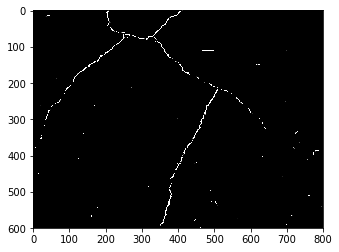

8


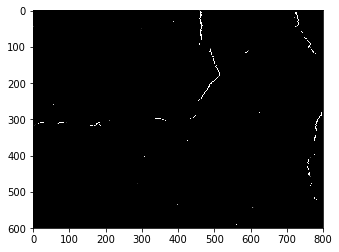

9


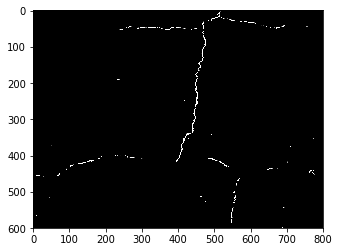

10


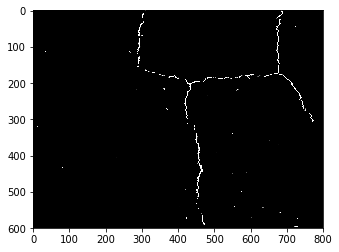

11


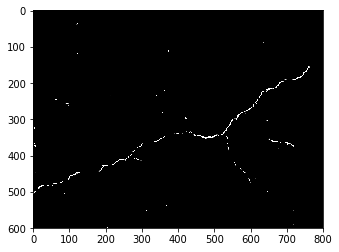

12


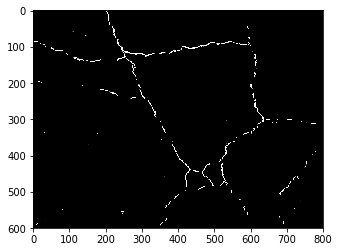

13


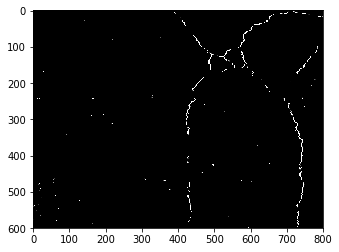

14


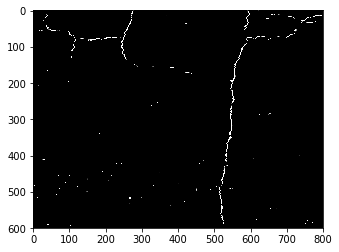

15


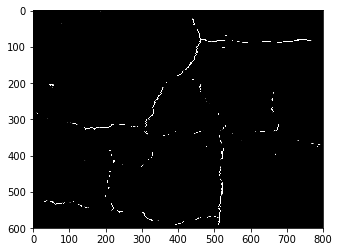

16


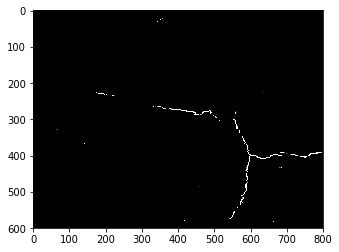

17


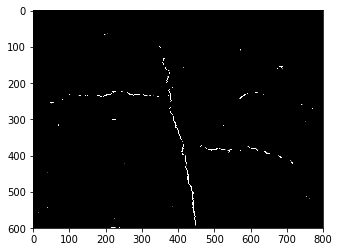

18


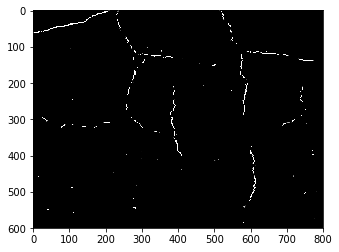

19


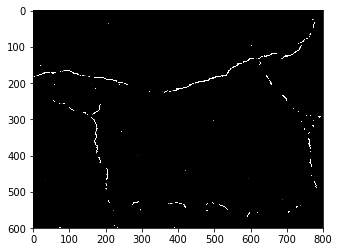

20


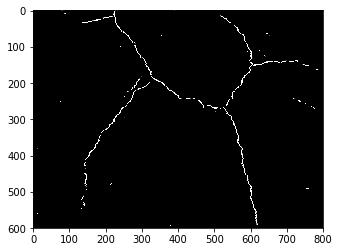

21


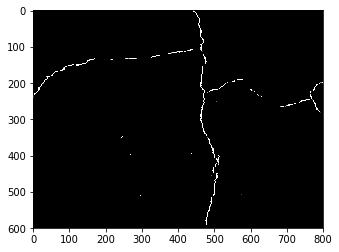

22


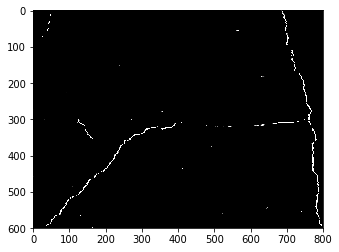

23


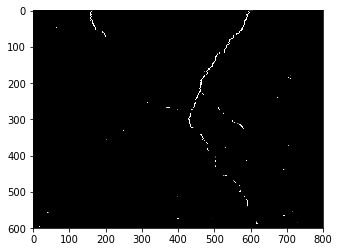

24


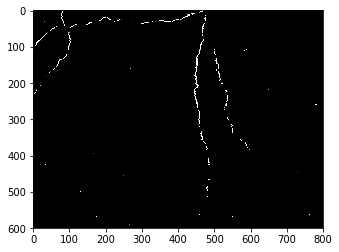

25


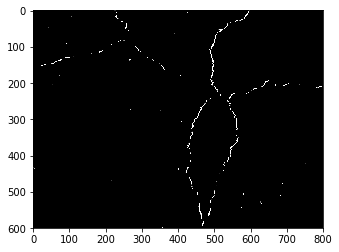

26


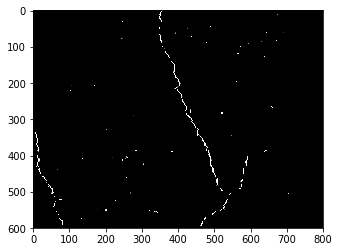

27


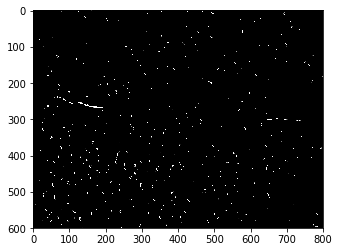

28


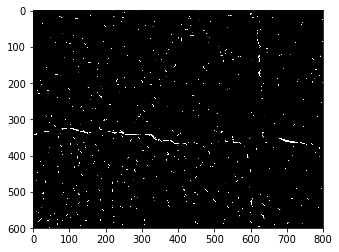

29


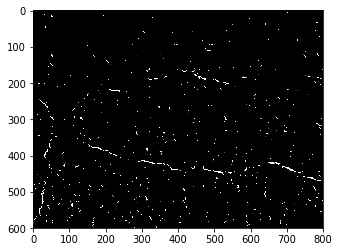

30


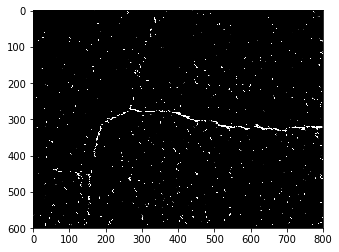

31


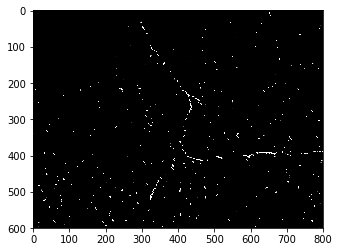

32


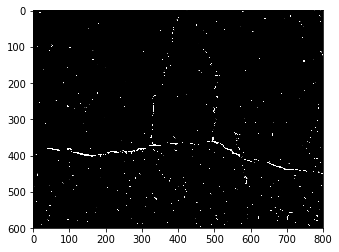

33


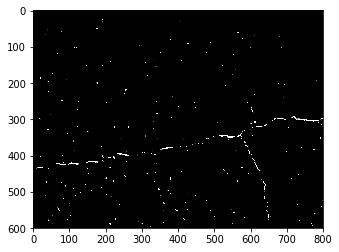

34


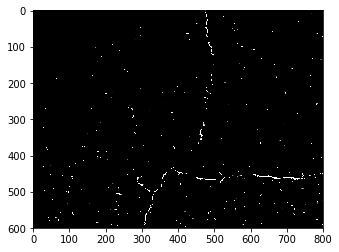

35


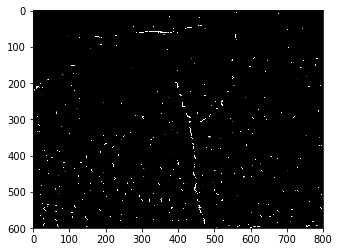

36


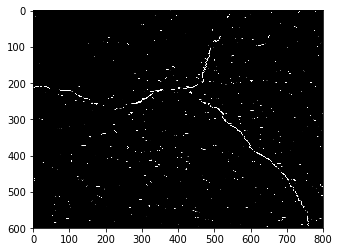

37


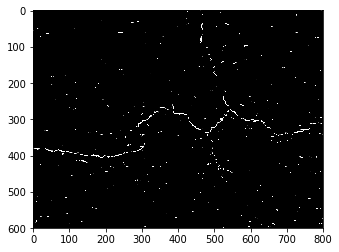

38


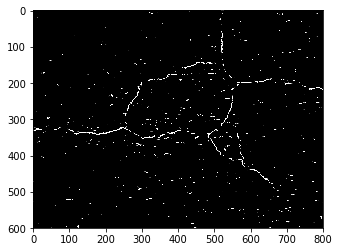

39


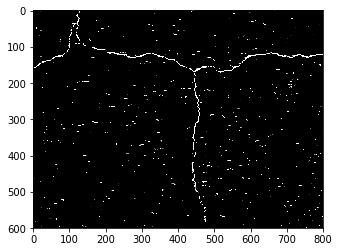

40


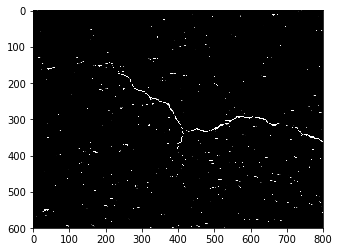

41


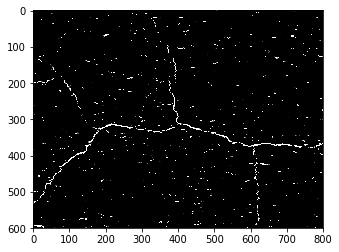

42


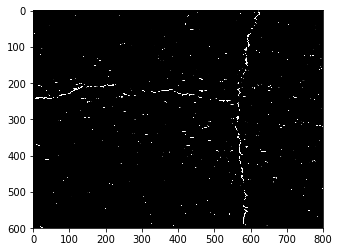

43


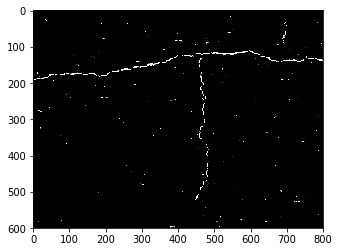

44


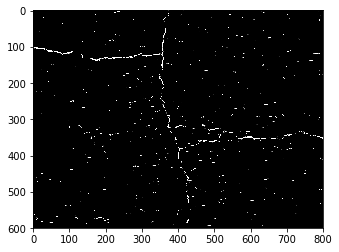

45


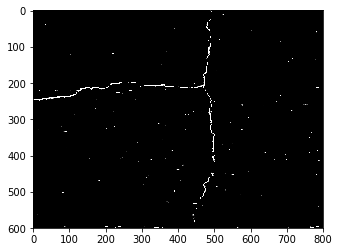

46


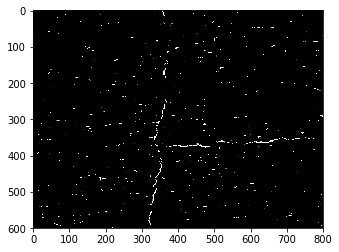

47


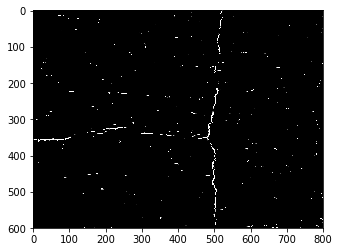

48


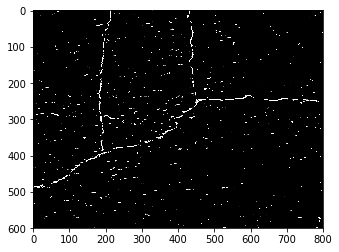

49


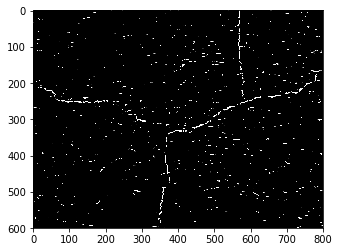

50


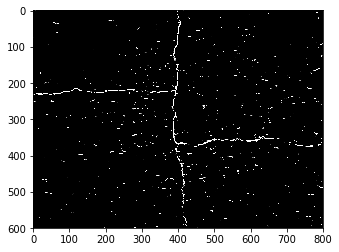

51


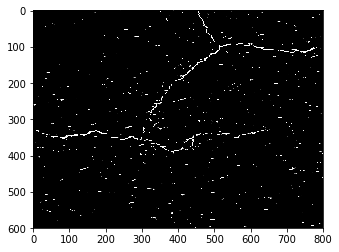

52


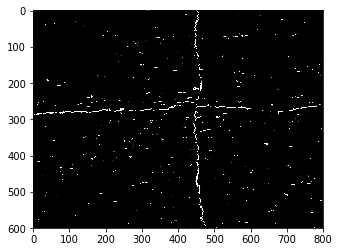

53


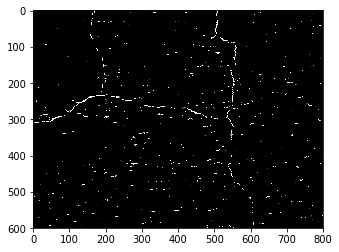

54


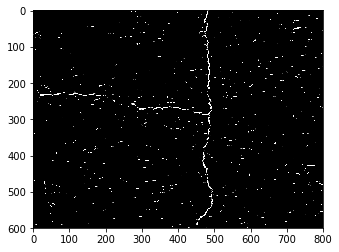

55


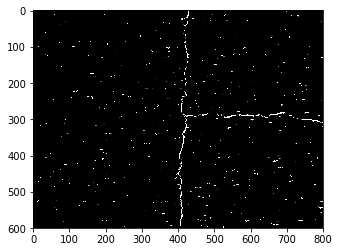

56


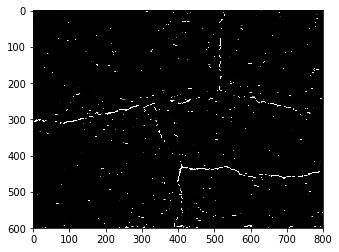

57


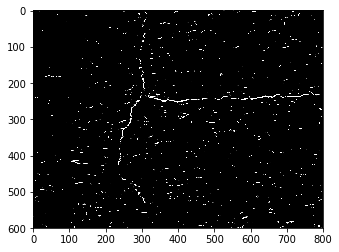

58


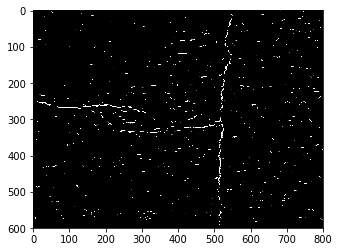

59


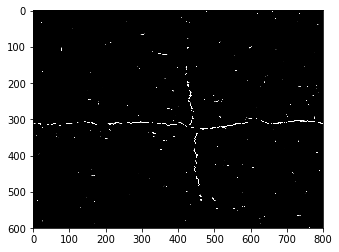

60


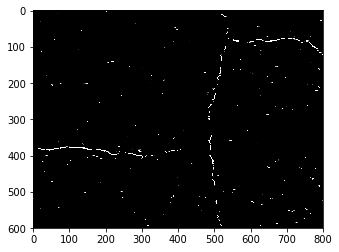

61


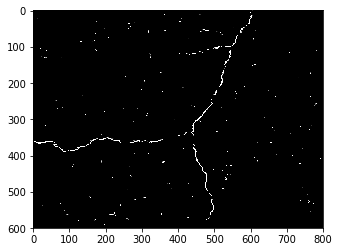

62


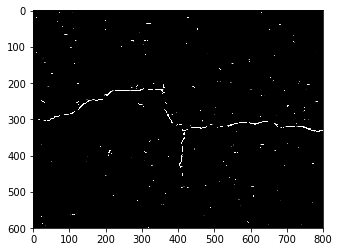

63


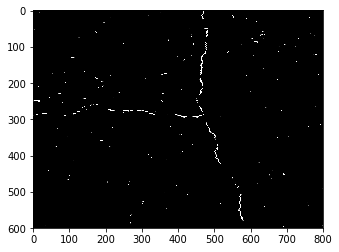

64


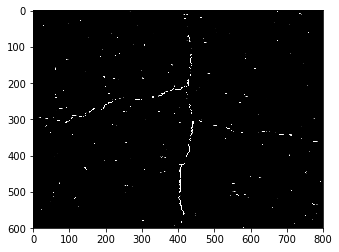

65


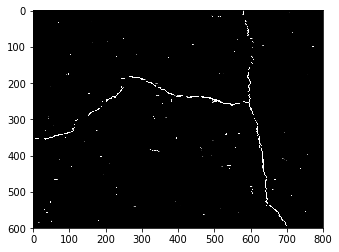

66


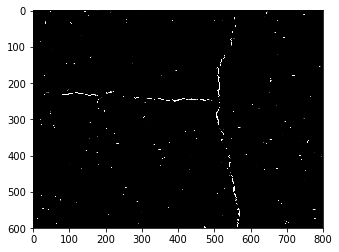

67


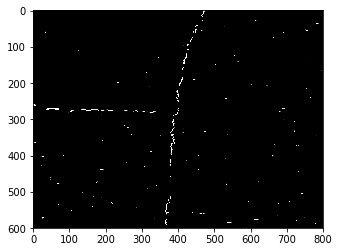

68


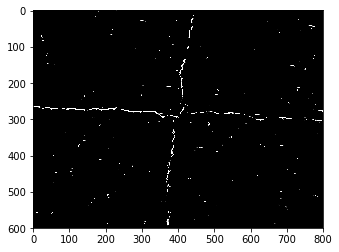

69


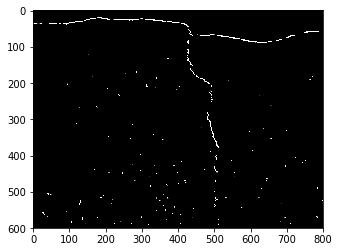

70


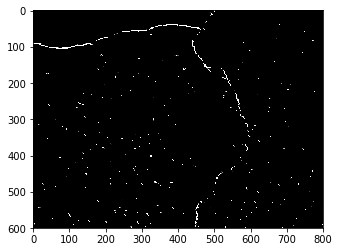

71


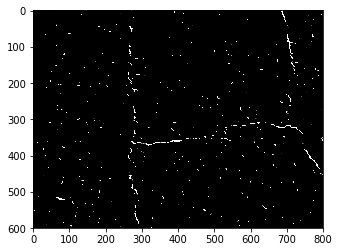

72


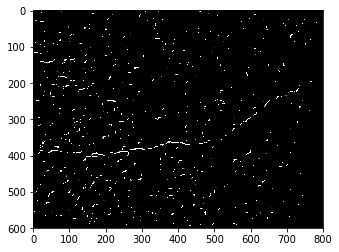

73


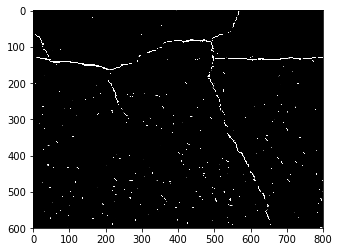

74


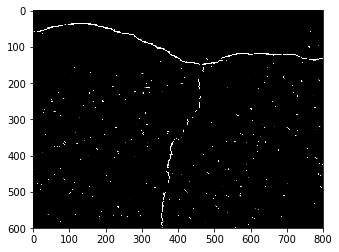

75


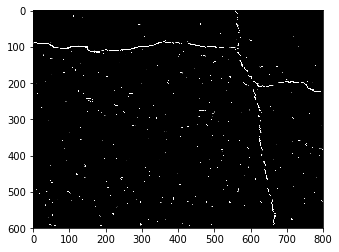

76


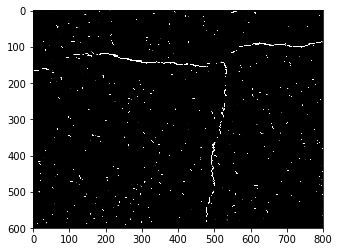

77


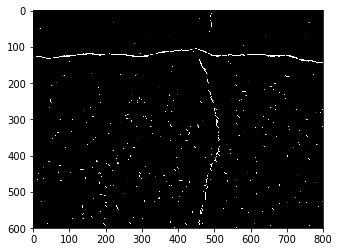

78


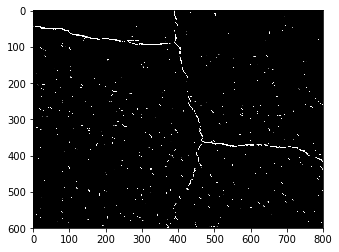

79


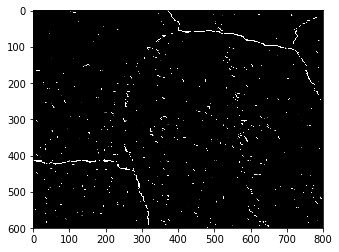

80


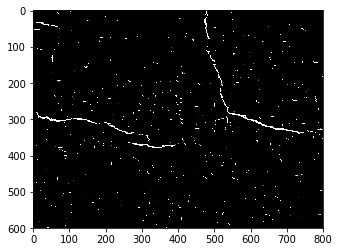

81


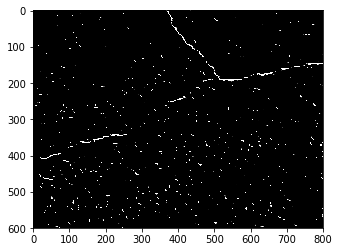

82


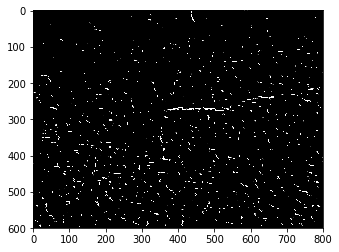

83


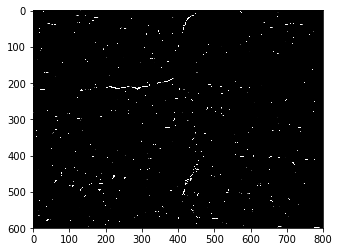

84


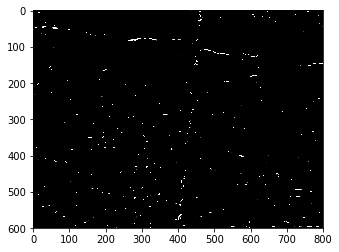

85


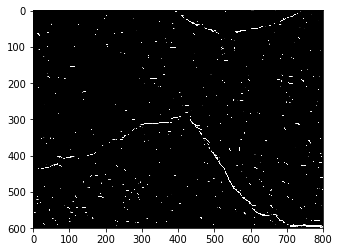

86


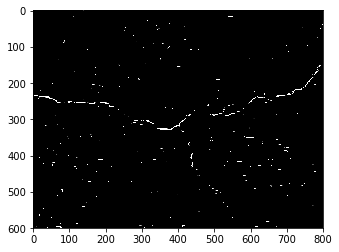

87


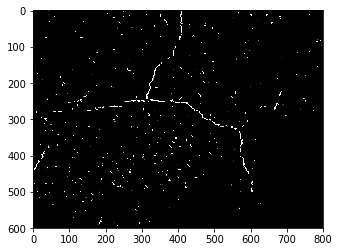

88


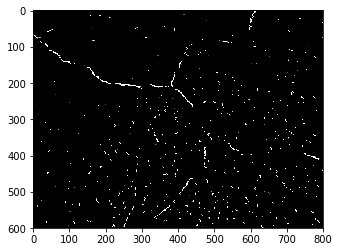

89


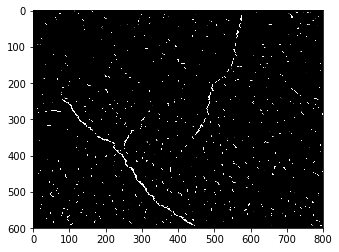

90


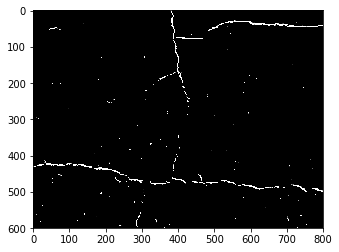

91


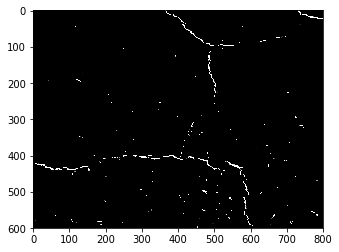

92


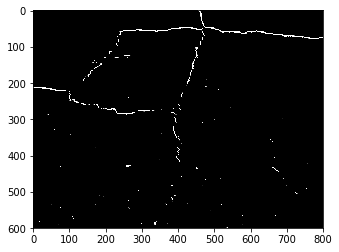

93


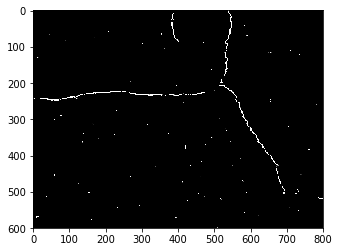

94


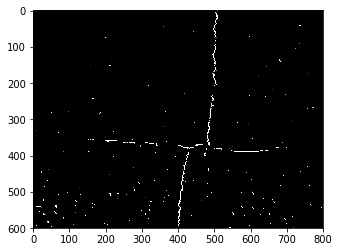

95


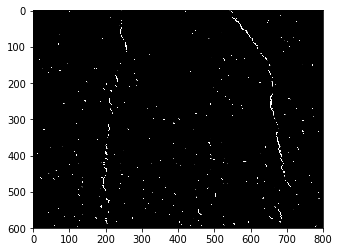

96


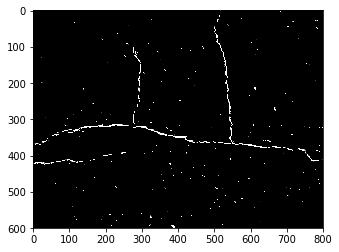

97


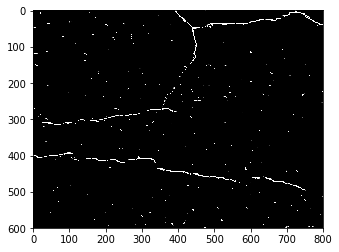

98


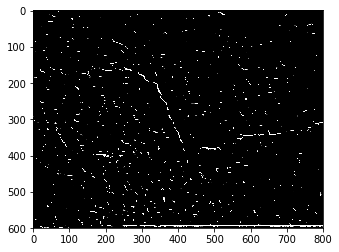

99


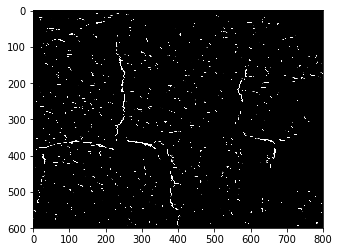

100


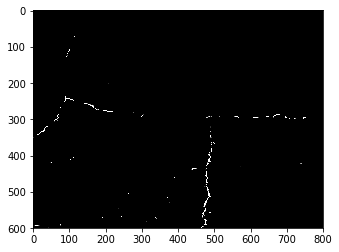

101


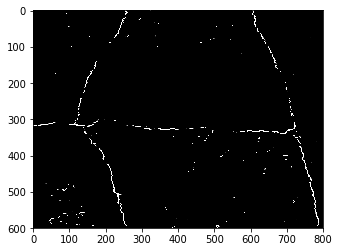

102


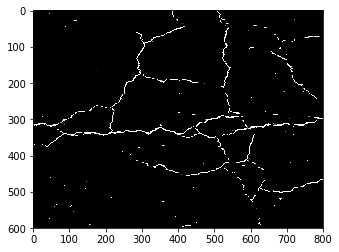

103


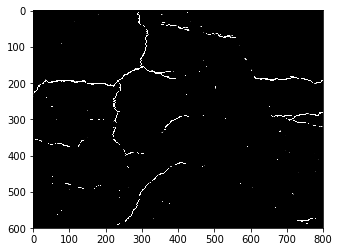

In [42]:
i = 0
for sequence in range(frames_img.shape[0]):
    i+=1
    print(i)
    plt.imshow(frames_img[sequence], cmap='gray')
    plt.pause(0.005)

In [43]:
print(np.unique(frames_img,return_counts=True))

(array([0.00000000e+00, 4.91738319e-06, 8.37445259e-06, ...,
       9.99991417e-01, 9.99999821e-01, 1.00000000e+00]), array([48824955,        1,        1, ...,        1,        1,   434694]))


In [46]:
def dice_score(y_true, y_pred, smooth=1):   
    intersection = np.sum(np.multiply(y_true ,y_pred))
    union = np.sum(y_true) + np.sum(y_pred)
    iou = (2. * intersection) / (union + K.epsilon())
#     print(iou)
    return iou

In [47]:
dice_scores = list()
for frames in range(len(frames_img)):
    dice_scores.append(dice_score(y_frames_img[frames],frames_img[frames]))
dice_scores = np.array(dice_scores)
print(np.mean(dice_scores))

0.28066917781584544


In [44]:
def my_iou(y_true, y_pred, threshold):
    intersection = 0
    union = 0
    miou = 0
    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            if(y_true[i][j] >= threshold and y_pred[i][j] >= threshold):
                intersection += 1
                union += 1
            
            if(y_true[i][j] >= threshold and y_pred[i][j] < threshold):
                union += 1
            
            if(y_true[i][j] < threshold and y_pred[i][j] >= threshold):
                union += 1
    
    miou = intersection/union
#     print(miou)
#     print(intersection, union)
    return miou

In [45]:
# print(np.unique(y_test))
# print(np.unique(y_pred))
# print(y_train.shape)
# print(y_pred.shape)
# print('Mean IOU:')
iou = 0
c = 0
# iou = np_mean_iou(y_pred, y_test)
for i in range(len(y_pred)):
    c+=1
#     print(c)
    iou += compute_iou(y_test[i], y_pred[i])
#     print(iou)
    
iou /= len(y_pred)
print(iou)

0.32662256767785064


In [ ]:
# with open('new_5_layer_softmax_loss_bin_cros_epochs_150_bs_1_input_32_256.json', 'w') as f:
#     json.dump(history.history, f)

history = json.load(open('5_layer_tanh_softmax_loss_dice_coef_loss_epochs_150_bs_32_input_4_1_256.json', 'r'))
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for iou
plt.plot(history['mean_iou'])
plt.plot(history['val_mean_iou'])
plt.title('model Mean IOU')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for F1
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
# print(len(np.unique(y_pred)))

In [ ]:
print(y_pred.shape)
y_pred = y_pred.reshape(199, 256, 256)
# y_pred[y_pred >= 0.5] = 1
# y_pred[y_pred < 0.5] = 0
for sequence in range(len(y_pred)):
    print('SEQUENCE')
    plt.imshow(y_pred[sequence], cmap='gray')
    plt.pause(0.005)

In [ ]:
print(y_train.shape)
y_train = y_train.reshape(199, 256, 256)
# y_test[y_test >= 0.5] = 1
# y_test[y_test < 0.5] = 0
for sequence in range(len(y_train)):
    print('SEQUENCE')
    plt.imshow(y_train[sequence], cmap='gray')
    plt.pause(0.005)

In [ ]:
print(x_test.shape)
x_test = x_test.reshape(1592, 256, 256, 3)
# y_test[y_test >= 0.5] = 1
# y_test[y_test < 0.5] = 0
for sequence in range(len(x_test)):
    print('SEQUENCE')
    plt.imshow(x_test[sequence], cmap='gray')
    plt.pause(0.005)

In [ ]:
print(np.unique(y_pred))
print(np.unique(y_test))
# print(y_train.shape)
# print(y_pred.shape)
# print('Mean IOU:')
iou = 0
# iou = np_mean_iou(y_pred, y_test)
for i in range(len(y_pred)):
#     print(compute_iou(y_test[i], y_pred[i]))
    iou += compute_iou(y_train[i], y_pred[i])
    
iou /= len(y_pred)
print(iou)

In [ ]:
# def get_model(pretrained_weights = None,input_size = (8, 1, 224, 3)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = (ConvLSTM2D(64, kernel_size=(1,9), activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.2)(bnorm1)
# #     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
#     #64
# #     conv2 = (ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(maxpool1)
# #     bnorm2 = BatchNormalization()(conv2)
# #     drop2 = Dropout(0.0)(bnorm2)
# #     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

#     #UpSampling
#     #128
# #     conv3 = (ConvLSTM2D(256, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(maxpool2)
# #     bnorm3 = BatchNormalization()(conv3)
# #     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
# #     merge1 = concatenate([maxpool1,up1], axis = 4)
# #     drop3 = Dropout(0.0)(merge1)
    
#     #256
# #     conv4 = (ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True))(drop3)
# #     bnorm4 = BatchNormalization()(conv4)
# #     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
# #     drop4 = Dropout(0.0)(up2)
    
# #     conv5 = ConvLSTM2D(64, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop4)
    
# #     conv6 = ConvLSTM2D(4, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv5)
# #     conv7 = ConvLSTM2D(2, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv6)
#     conv5 = ConvLSTM2D(1, kernel_size=(1,9), activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop1)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
    
# #     model = make_parallel(model, gpu_count=2)

    
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-3), loss = loss, metrics = ['accuracy', dice_coef, mean_iou])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model

In [ ]:
# def get_model(pretrained_weights = None,input_size = (None, 1, 256, 1)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = ConvLSTM2D(256, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.0)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
#     #64
#     conv2 = ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool1)
#     bnorm2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.0)(bnorm2)
#     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

#     #UpSampling
#     #128
#     conv3 = ConvLSTM2D(256, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool2)
#     bnorm3 = BatchNormalization()(conv3)
#     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
#     merge1 = concatenate([maxpool1,up1], axis = 4)
#     drop3 = Dropout(0.0)(merge1)
    
#     #256
#     conv4 = ConvLSTM2D(128, 3, activation = 'tanh',padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop3)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.0)(up2)
    
# #     conv5 = ConvLSTM2D(64, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop4)
    
# #     conv6 = ConvLSTM2D(4, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv5)
# #     conv7 = ConvLSTM2D(2, 3, activation = 'tanh',recurrent_activation='tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(conv6)
#     conv5 = ConvLSTM2D(1, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop4)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = loss, metrics = ['accuracy', dice_coef])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model

In [ ]:
# def get_model(pretrained_weights = None,input_size = (32, 1, 256, 3)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.2)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
#     #64
#     conv2 = ConvLSTM2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool1)
#     bnorm2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.2)(bnorm2)
#     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

#     #UpSampling
#     #128
#     conv3 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool2)
#     bnorm3 = BatchNormalization()(conv3)
#     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
#     merge1 = concatenate([maxpool1,up1], axis = 4)
#     drop3 = Dropout(0.2)(merge1)
    
#     #256
#     conv4 = ConvLSTM2D(16, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop3)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.2)(up2)
    
#     conv5 = ConvLSTM2D(1, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop4)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy', dice_coef, mean_iou, jaccard_distance])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model

In [ ]:
# def get_model(pretrained_weights = None,input_size = (4, 1, 256, 3)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.2)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
    
#     #256
#     conv4 = ConvLSTM2D(16, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool1)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.2)(up2)
    
#     conv5 = ConvLSTM2D(1, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop4)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy', dice_coef, mean_iou, jaccard_distance])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model

In [ ]:
# def get_model(pretrained_weights = None,input_size = (32, 1, 256, 1)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.4)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
#     #64
#     conv2 = ConvLSTM2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool1)
#     bnorm2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.4)(bnorm2)
#     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

#     #UpSampling
#     #128
#     conv3 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool2)
#     bnorm3 = BatchNormalization()(conv3)
#     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
#     merge1 = concatenate([maxpool1,up1], axis = 4)
#     drop3 = Dropout(0.4)(merge1)
    
#     #256
#     conv4 = ConvLSTM2D(16, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop3)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.4)(up2)
    
#     conv5 = ConvLSTM2D(1, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop4)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy', dice_coef, mean_iou, jaccard_distance])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model

In [ ]:
# def get_model(pretrained_weights = None,input_size = (64, 1, 256, 1)):
#     inputs = Input(input_size)
    
#     #DownSampling
#     #128
#     conv1 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(inputs)
#     bnorm1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.2)(bnorm1)
#     maxpool1 = MaxPooling3D(pool_size=(1,1,2))(drop1)
    
#     #64
#     conv2 = ConvLSTM2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool1)
#     bnorm2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.2)(bnorm2)
#     maxpool2 = MaxPooling3D(pool_size=(1,1,2))(drop2)

#     #UpSampling
#     #128
#     conv3 = ConvLSTM2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(maxpool2)
#     bnorm3 = BatchNormalization()(conv3)
#     up1 = UpSampling3D(size=(1,1,2))(bnorm3)    
#     merge1 = concatenate([maxpool1,up1], axis = 4)
#     drop3 = Dropout(0.2)(merge1)
    
#     #256
#     conv4 = ConvLSTM2D(16, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', return_sequences=True)(drop3)
#     bnorm4 = BatchNormalization()(conv4)
#     up2 = UpSampling3D(size=(1,1,2))(bnorm4)
#     drop4 = Dropout(0.2)(up2)
    
#     conv5 = ConvLSTM2D(1, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', return_sequences=False)(drop4)
    
# #     conv6 = Conv2D(1, 3, padding = 'same', activation = 'softmax')(conv5)
    
#     #Model                     
#     model = Model(input = inputs, output = conv5)
#     model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy', dice_coef, mean_iou, jaccard_distance])
    
#     if(pretrained_weights):
#         print('loading_weights')
#         model.load_weights(pretrained_weights)

#     return model